In [1]:
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from collections import Counter # Used by evaluate_problem_self_consistency_v3
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# --- Matplotlib Global Style Settings ---
try:
    plt.rcParams['font.family'] = 'Avenir'
except RuntimeError:
    print("Avenir font not found. Using default Matplotlib font.")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.size'] = 0  # Hides x-axis tick lines
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['axes.grid'] = True # Enable grid by default, can be fine-tuned per plot
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
# Increase default figure size globally, can be overridden per plot
plt.rcParams['figure.figsize'] = [12, 7] # General increase in plot size


# --- Coordinated Color Scheme ---
# Define a consistent color map strategy for experiment types across figures.
# Self-Consistency will be dark gray. Backtracking will be black.
# Other methods will get colors from a specified colormap.

SELF_CONSISTENCY_LABEL_FIG2 = "Self-Consistency (Cond. Fractional)" # Label used in Figure 2
# Placeholder for a generic SC key if SC data appears as an 'experiment_type' in Figure 1's CSV
# For now, we assume SC is handled separately and not an 'experiment_type' in Fig 1 data.
# If SC could be an 'experiment_type', its raw name from data should be used here for mapping.
# Example: SELF_CONSISTENCY_RAW_EXP_TYPE_FOR_MAP = "self_consistency_data_key"

SELF_CONSISTENCY_COLOR = 'darkgray'
# BACKTRACKING_EXPERIMENT_TYPE = 'backtracking' # Raw experiment_type string for backtracking
# BACKTRACKING_COLOR = 'black'
DEFAULT_CMAP_FOR_OTHERS = 'Set2' # Colormap for other experiment types

def build_color_map(all_method_names, sc_method_names_in_plot, backtracking_name_in_plot):
    """
    Builds a color map for a list of method names.
    Args:
        all_method_names (list): List of all unique method names to be plotted.
        sc_method_names_in_plot (list): List of names representing self-consistency (to be dark gray).
        backtracking_name_in_plot (str): Name for backtracking (to be black).
    Returns:
        dict: A dictionary mapping method names to colors.
    """
    color_map = {}
    
    # Assign Self-Consistency color(s)
    for name in sc_method_names_in_plot:
        if name in all_method_names:
            color_map[name] = SELF_CONSISTENCY_COLOR
            
    # # Assign Backtracking color
    # if backtracking_name_in_plot and backtracking_name_in_plot in all_method_names:
    #     color_map[backtracking_name_in_plot] = BACKTRACKING_COLOR
        
    # Assign colors to remaining methods
    # Ensure consistent ordering for color assignment if all_method_names is not pre-sorted
    # However, typically all_method_names would be sorted before calling this for reproducibility
    other_methods = sorted([
        name for name in all_method_names 
        if name not in color_map  # Not already colored (SC or Backtracking)
    ])
    
    # Use a specific colormap for these other methods
    num_other_methods = len(other_methods)
    cmap = plt.cm.get_cmap(DEFAULT_CMAP_FOR_OTHERS, max(1, num_other_methods))
    
    for i, name in enumerate(other_methods):
        color_map[name] = cmap(i)
        
    return color_map


# --- Helper Functions from consensus.ipynb (Adapted) ---
def evaluate_problem_self_consistency_v3(problem_data):
    solutions = problem_data.get("solutions", [])
    correct_answer_ground_truth = problem_data.get("correct_answer")
    default_answer_counts = Counter()

    if not solutions or correct_answer_ground_truth is None:
        return 0.0, None, default_answer_counts, False

    answer_submissions = []
    for i, sol in enumerate(solutions):
        answer = sol.get("answer")
        if answer is not None and isinstance(answer, str) and answer.strip():
            answer_submissions.append({"answer_text": answer, "index": i})

    if not answer_submissions:
        return 0.0, None, default_answer_counts, False

    answer_counts = Counter(sub["answer_text"] for sub in answer_submissions)
    correct_answer_str = str(correct_answer_ground_truth).strip()
    
    max_freq = 0
    if answer_counts: max_freq = max(answer_counts.values())
    else: return 0.0, None, default_answer_counts, False

    candidate_answers_set = {ans_text for ans_text, freq in answer_counts.items() if freq == max_freq}
    was_tie_in_frequency = len(candidate_answers_set) > 1
    
    majority_voted_answer_by_index = None
    if not candidate_answers_set: return 0.0, None, answer_counts, False 
    if len(candidate_answers_set) == 1:
        majority_voted_answer_by_index = list(candidate_answers_set)[0]
    else: 
        min_index_for_tied_answers = float('inf')
        for tied_ans_option in candidate_answers_set:
            for sub in answer_submissions:
                if sub["answer_text"] == tied_ans_option:
                    if sub["index"] < min_index_for_tied_answers:
                        min_index_for_tied_answers = sub["index"]
                        majority_voted_answer_by_index = tied_ans_option
                    break 
    
    consistency_score = 0.0
    if was_tie_in_frequency and correct_answer_str in candidate_answers_set:
        num_times_correct_answer_appeared = answer_counts.get(correct_answer_str, 0)
        total_number_of_solution_slots = len(solutions)
        if total_number_of_solution_slots > 0:
            consistency_score = num_times_correct_answer_appeared / total_number_of_solution_slots
    else:
        if majority_voted_answer_by_index is not None and \
           str(majority_voted_answer_by_index).strip() == correct_answer_str:
            consistency_score = 1.0
        else:
            consistency_score = 0.0
            
    return consistency_score, majority_voted_answer_by_index, answer_counts, was_tie_in_frequency

def split_into_2024_2025(problem_list):
    results_2024 = []
    results_2025 = []
    if not isinstance(problem_list, list):
        return results_2024, results_2025
    for res_item in problem_list:
        if not isinstance(res_item, dict):
            continue
        problem_id = res_item.get('problem_id')
        if problem_id is None: 
            results_2025.append(res_item) 
            continue
        if isinstance(problem_id, str) and problem_id.startswith('2024'):
            results_2024.append(res_item)
        else: 
            results_2025.append(res_item)
    return results_2024, results_2025

def get_mean_and_sem(series):
    series = series.dropna() 
    if series.empty: return 0, 0
    mean_val = series.mean()
    sem_val = sem(series) if len(series) >= 2 else 0.0 
    return mean_val, sem_val

def get_self_consistency_data(base_dir="pass_consensus"):
    all_problem_analysis_data = []
    seed_files_info = [
        {"filename": "seed0_pass_consensus.json", "seed_num_str": "s0"},
        {"filename": "seed1_pass_consensus.json", "seed_num_str": "s1"},
        {"filename": "seed2_pass_consensus.json", "seed_num_str": "s2"},
        {"filename": "seed3_pass_consensus.json", "seed_num_str": "s3"}
    ]
    print(f"Looking for self-consistency files in directory: {os.path.abspath(base_dir)}")
    for file_info in seed_files_info:
        filepath = os.path.join(base_dir, file_info["filename"])
        seed_num_str = file_info["seed_num_str"]
        
        if not os.path.exists(filepath):
            print(f"  Warning: File not found: {filepath}. Skipping.")
            continue
        try:
            with open(filepath, 'r', encoding='utf-8') as f: data = json.load(f)
        except Exception as e:
            print(f"  Error loading/parsing {filepath}: {e}. Skipping.")
            continue
        
        if "results" not in data or not isinstance(data["results"], list):
            print(f"  Warning: 'results' key missing/invalid in {filepath}. Skipping.")
            continue
            
        problems_all_for_file = data["results"]
        results_2024_seed, results_2025_seed = split_into_2024_2025(problems_all_for_file)
        
        datasets_to_process_for_seed = [
            {'base_year': 2024, 'problem_list': results_2024_seed},
            {'base_year': 2025, 'problem_list': results_2025_seed}
        ]
        
        for dataset in datasets_to_process_for_seed:
            for problem_entry in dataset['problem_list']:
                if not isinstance(problem_entry, dict): continue
                consistency_score, _, _, _ = \
                    evaluate_problem_self_consistency_v3(problem_entry)
                
                problem_result_data = {
                    "problem_id": problem_entry.get("problem_id"),
                    "base_year": dataset['base_year'],
                    "seed": seed_num_str,
                    "self_consistent_score": consistency_score 
                }
                all_problem_analysis_data.append(problem_result_data)
                
    if not all_problem_analysis_data:
        print("\nNo self-consistency data processed.")
        return pd.DataFrame()
        
    overall_self_consistency_df = pd.DataFrame(all_problem_analysis_data)
    overall_self_consistency_df['self_consistent_score'] = pd.to_numeric(overall_self_consistency_df['self_consistent_score'], errors='coerce')
    overall_self_consistency_df.dropna(subset=['self_consistent_score'], inplace=True)
    return overall_self_consistency_df


--- Generating Figure 1: Scaling Plots ---
Looking for self-consistency files in directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus


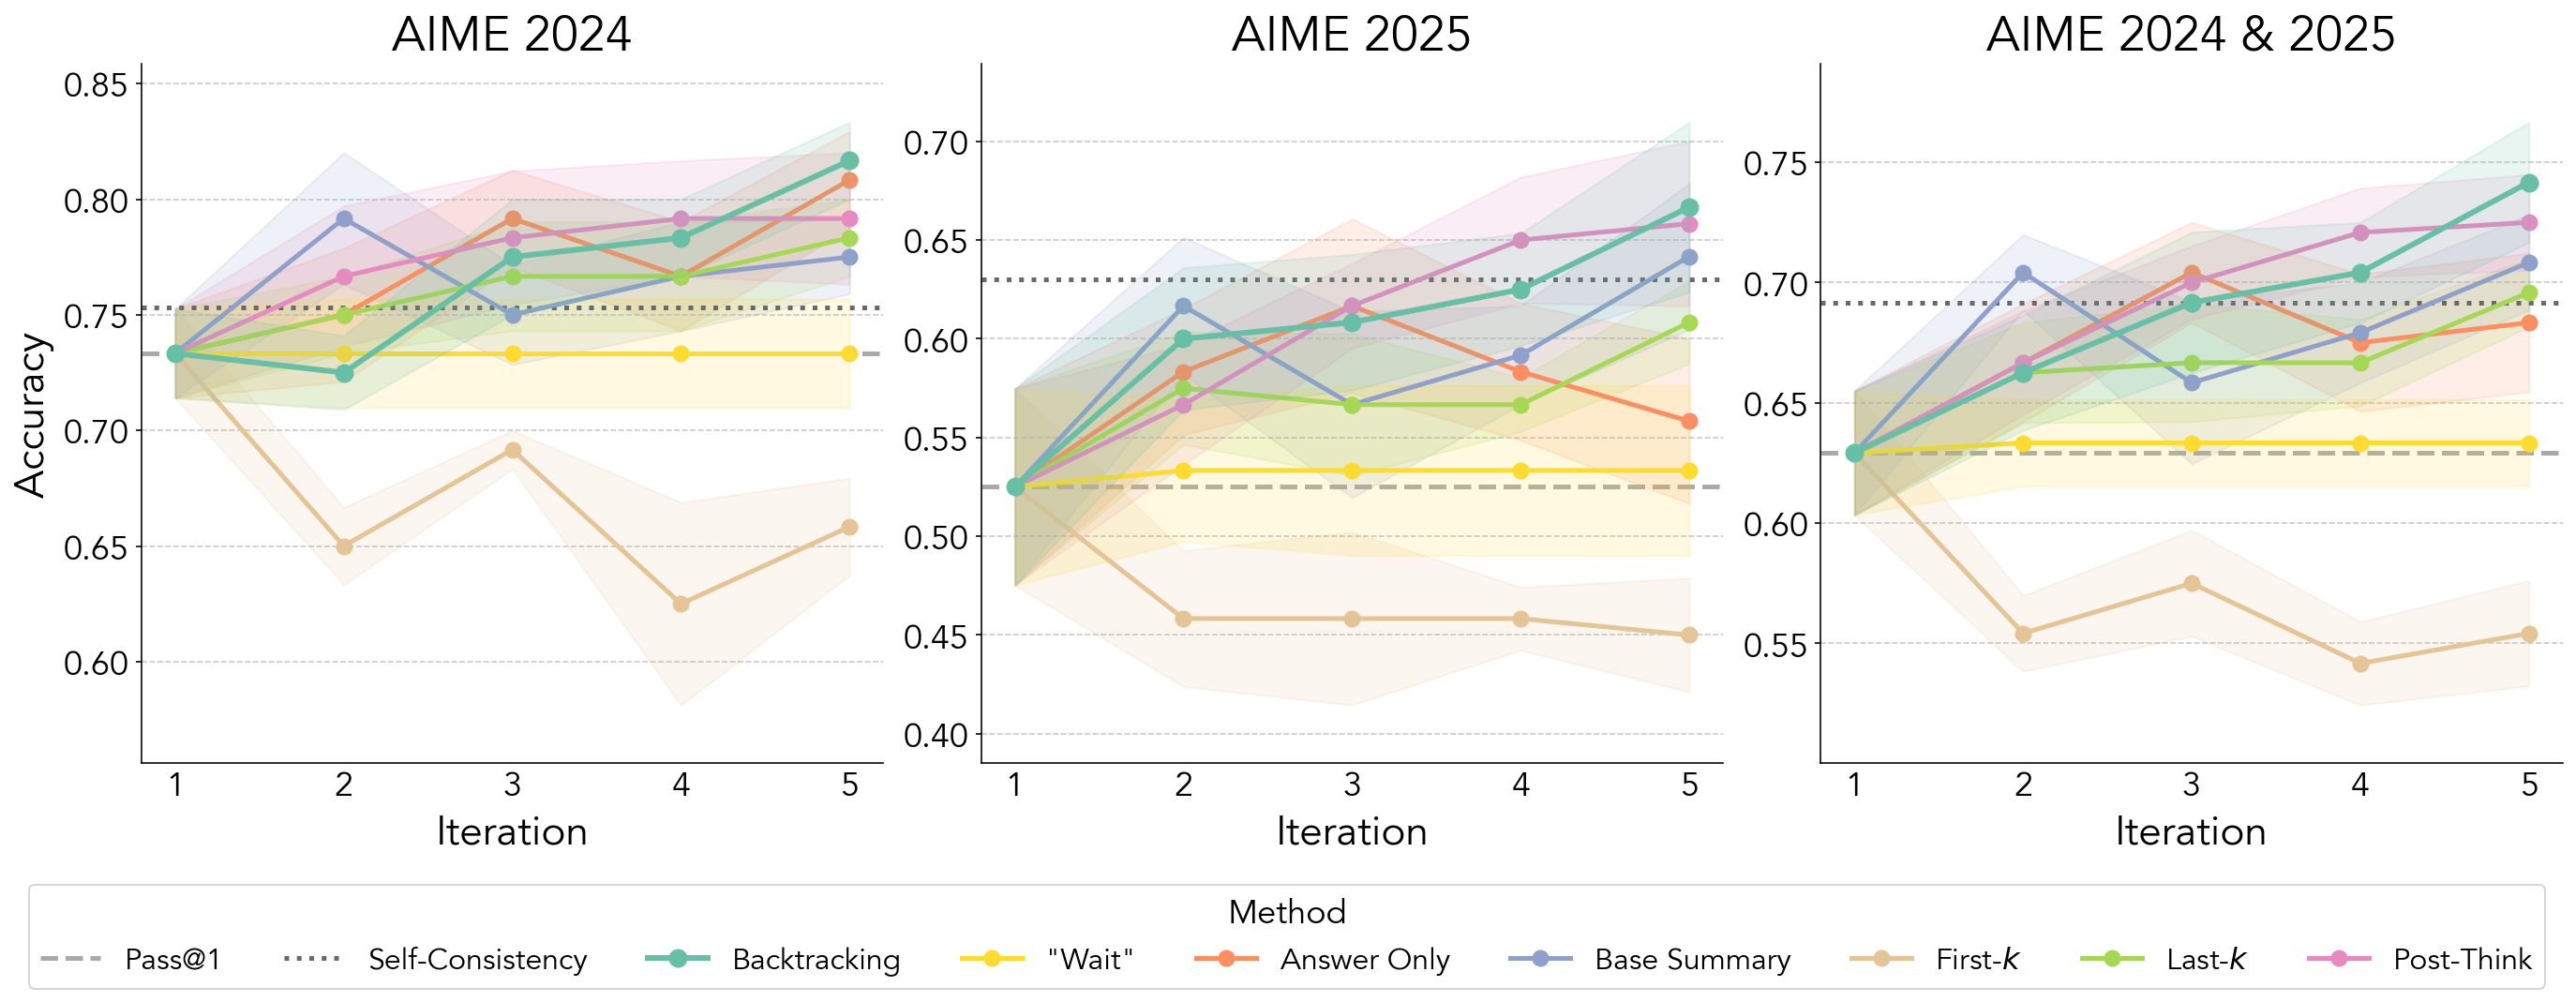


--- Generating Figure 2: Grouped Bar Plot ---
Looking for self-consistency files in directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/pass_consensus


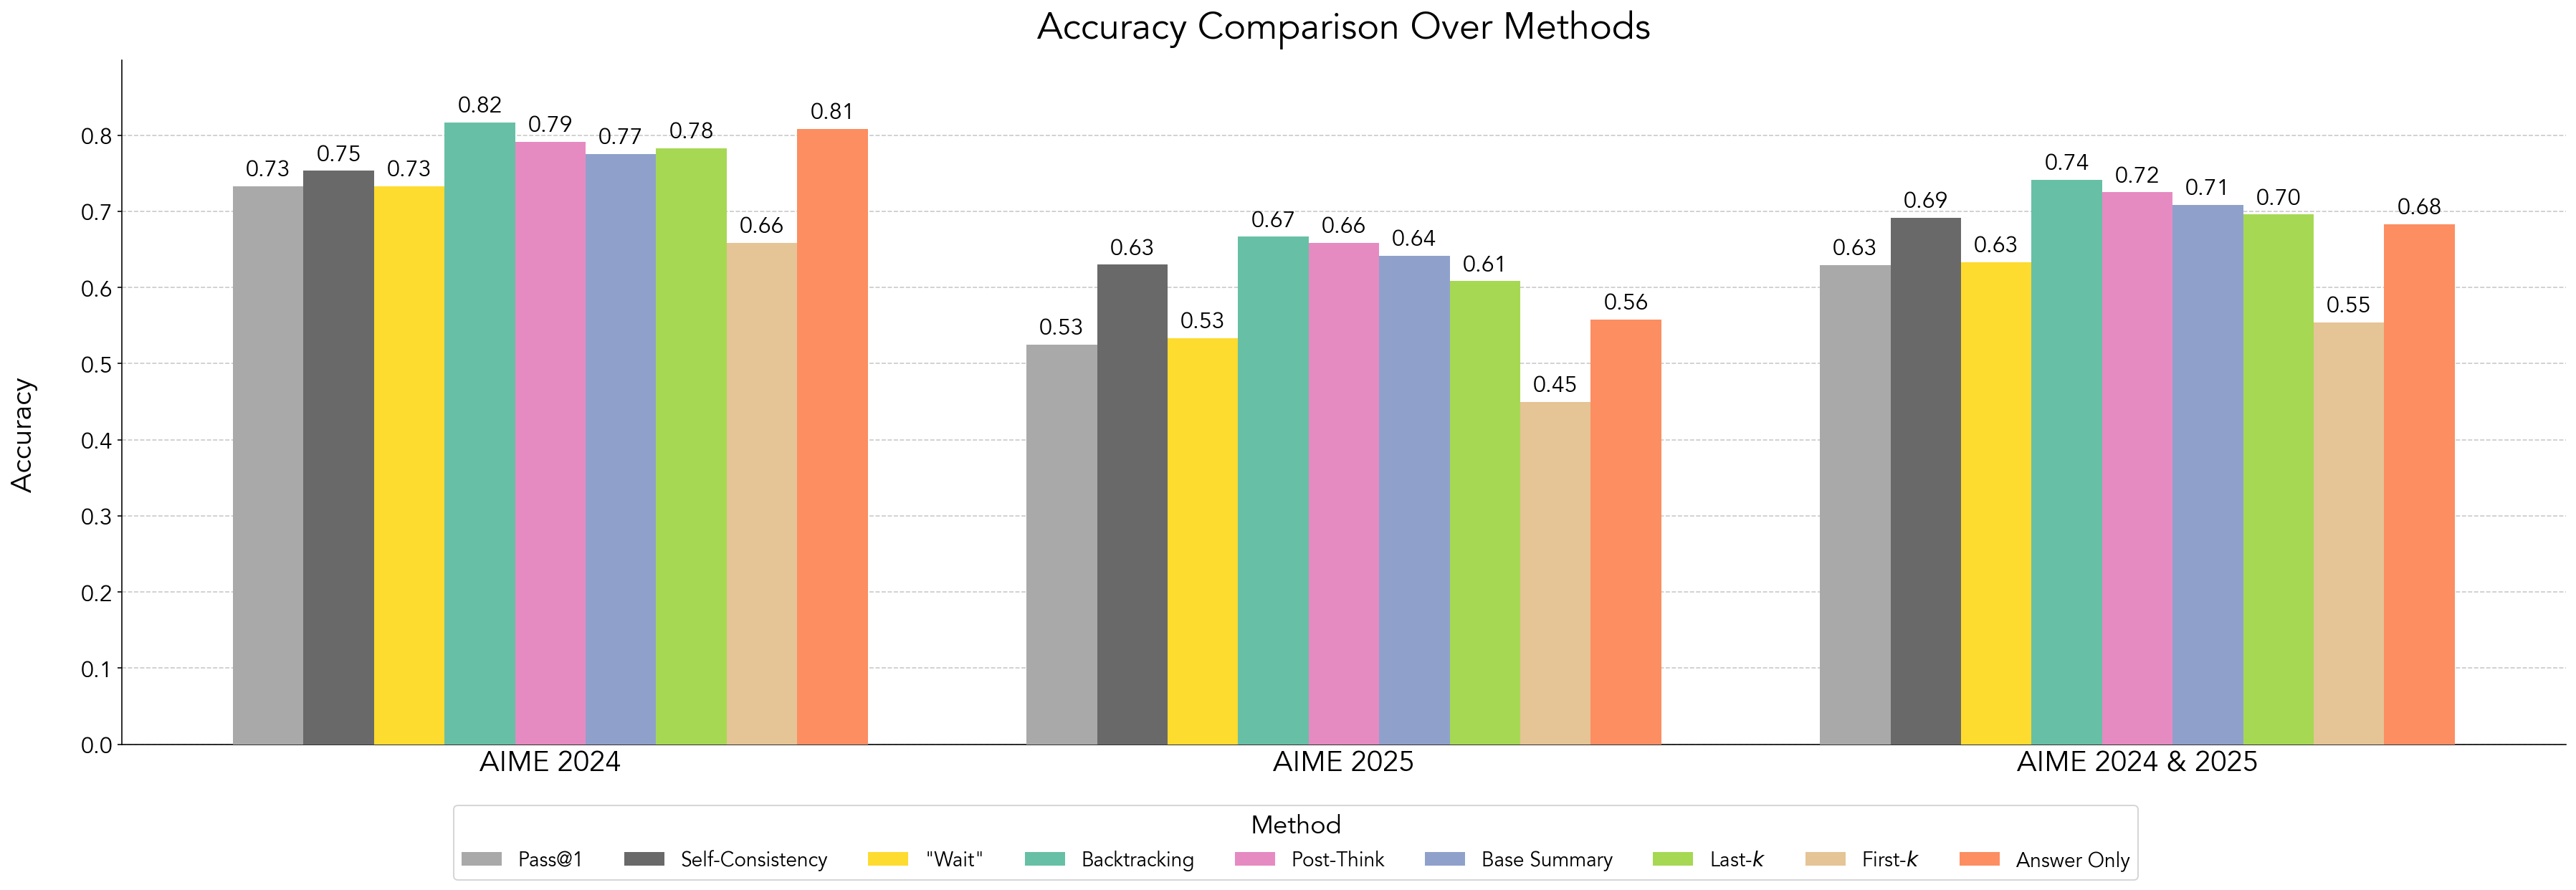


--- Summary of Results (Mean ± SEM) ---
Figure       Year Group           Method Iteration  Mean   SEM
  Fig1        AIME 2024           "Wait"         1 0.733 0.019
  Fig1        AIME 2024           "Wait"         2 0.733 0.024
  Fig1        AIME 2024           "Wait"         3 0.733 0.024
  Fig1        AIME 2024           "Wait"         4 0.733 0.024
  Fig1        AIME 2024           "Wait"         5 0.733 0.024
  Fig1        AIME 2024      Answer Only         1 0.733 0.019
  Fig1        AIME 2024      Answer Only         2 0.750 0.029
  Fig1        AIME 2024      Answer Only         3 0.792 0.021
  Fig1        AIME 2024      Answer Only         4 0.767 0.024
  Fig1        AIME 2024      Answer Only         5 0.808 0.021
  Fig1        AIME 2024     Backtracking         1 0.733 0.019
  Fig1        AIME 2024     Backtracking         2 0.725 0.016
  Fig1        AIME 2024     Backtracking         3 0.775 0.025
  Fig1        AIME 2024     Backtracking         4 0.783 0.017
  Fig1        

In [5]:
# --- Global Plotting Configuration ---
# EXPERIMENTAL_GROUP_COLORS defines the palette for different experimental methods,
# excluding Self-Consistency and Pass@1 which have fixed colors.
EXPERIMENTAL_GROUP_COLORS = [
    '#FC8E62',  # Answer Only
    '#67C0A5',  # Backtracking
    '#8FA1CB',  # Base Summary
    '#E5C495',  # First-$k$
    '#A6D853',  # Last-$k$
    '#E68AC2', # Post-Think
    '#FEDB2F',  # "Wait"
]

METHOD_DISPLAY_NAME_MAP = {
    "backtracking": "Backtracking",
    "base_sum": "Base Summary",
    "firstk": "First-$k$",
    "lastk": "Last-$k$",
    "postThink": "Post-Think",
    "wait": '"Wait"', # Added for the new experiment
    "Self-Consistency Score": "Self-Consistency",  # Used as input label for SC line in Figure 1
    "Self-Consistency (Cond. Fractional)": "Self-Consistency", # Used as input label for SC method in Figure 2
    "Pass@1 Score": "Pass@1", # For Figure 1 line label
    "Pass@1": "Pass@1",       # For Figure 2 bar label & internal key for data,
    'answer_only': 'Answer Only'
}


# For consistent color mapping across figures
METHOD_COLOR_PALETTE = {
    # Predefined colors for specific methods (using canonical raw names as keys)
    "Self-Consistency": "dimgray",
    "Pass@1": "darkgray",        # Color for Pass@1
    # Other raw base method names (e.g., "firstk") will be populated by populate_method_colors
}
# Stores the order of methods that get colors from EXPERIMENTAL_GROUP_COLORS, for reproducibility
_OTHER_METHODS_ORDER_FOR_PALETTE = []

def get_canonical_raw_name(original_raw_name):
    """Converts various raw method names to a single canonical form for color/display mapping."""
    if original_raw_name in ["Self-Consistency Score", "Self-Consistency (Cond. Fractional)"]:
        return "Self-Consistency"
    if original_raw_name in ["Pass@1 Score", "Pass@1"]: # Handles Fig1 label and Fig2 key
        return "Pass@1"
    suffix_iter4 = " (Iter 4)"
    if original_raw_name.endswith(suffix_iter4):
        return original_raw_name[:-len(suffix_iter4)]
    return original_raw_name

def populate_method_colors(all_raw_base_experiment_types):
    """
    Populates METHOD_COLOR_PALETTE for experiment types not already defined,
    using the EXPERIMENTAL_GROUP_COLORS list.
    """
    global _OTHER_METHODS_ORDER_FOR_PALETTE, METHOD_COLOR_PALETTE, EXPERIMENTAL_GROUP_COLORS

    # Ensure predefined keys for SC and Pass@1 have their colors
    METHOD_COLOR_PALETTE.setdefault("Self-Consistency", "dimgray")
    METHOD_COLOR_PALETTE.setdefault("Pass@1", "darkgray")

    # Identify methods that need a color from the experimental group palette
    # These are methods not already in METHOD_COLOR_PALETTE (e.g., not SC or Pass@1)
    methods_needing_color = sorted([
        name for name in list(set(all_raw_base_experiment_types))
        if name not in METHOD_COLOR_PALETTE
    ])

    _OTHER_METHODS_ORDER_FOR_PALETTE = methods_needing_color

    for i, raw_base_name in enumerate(methods_needing_color):
        if i < len(EXPERIMENTAL_GROUP_COLORS):
            METHOD_COLOR_PALETTE[raw_base_name] = EXPERIMENTAL_GROUP_COLORS[i]
        else:
            # If there are more unique experiment types than colors in EXPERIMENTAL_GROUP_COLORS,
            # print a warning. These methods will default to 'gray' via get_method_color.
            print(f"Warning: Ran out of predefined experimental group colors. Method '{raw_base_name}' (and subsequent) will use default color.")
            break # Stop assigning from the limited list

def get_method_color(original_raw_name):
    """Gets the color for a given raw method name."""
    canonical_name = get_canonical_raw_name(original_raw_name)
    if canonical_name not in METHOD_COLOR_PALETTE:
        print(f"Warning: Color for method '{canonical_name}' (from '{original_raw_name}') not found. Defaulting to gray.")
        return 'gray'
    return METHOD_COLOR_PALETTE[canonical_name]

def get_display_name(original_name, for_legend_fig2=False):
    """Gets the display-friendly name for methods."""
    if original_name in METHOD_DISPLAY_NAME_MAP:
        return METHOD_DISPLAY_NAME_MAP[original_name]

    suffix_iter4 = " (Iter 4)"
    if original_name.endswith(suffix_iter4):
        base_name = original_name[:-len(suffix_iter4)]
        display_base = METHOD_DISPLAY_NAME_MAP.get(base_name, base_name)
        return display_base if for_legend_fig2 else f"{display_base}{suffix_iter4}"

    return METHOD_DISPLAY_NAME_MAP.get(original_name, original_name)

# --- Plotting Functions ---
def plot_scaling_accuracy_by_iteration(results_df, plot_title_suffix="", ax=None,
                                       self_consistency_score=None, self_consistency_label="Self-Consistency Score",
                                       pass_at_1_score=None, pass_at_1_label="Pass@1 Score", set_y_label=True): # Added set_y_label
    if results_df.empty:
        if ax: ax.text(0.5, 0.5, "No data available", ha='center', va='center')
        print(f"Input DataFrame empty for '{plot_title_suffix}'. Cannot generate scaling plot.")
        return None, None, None

    iteration_cols = [f'iteration_{i}_correct' for i in range(5)]
    required_cols = ['experiment_type', 'seed'] + iteration_cols
    if any(col not in results_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in results_df.columns]
        if ax: ax.text(0.5, 0.5, f"Missing columns:\n{', '.join(missing)}", ha='center', va='center', wrap=True)
        print(f"Missing columns: {missing} for '{plot_title_suffix}'. Cannot generate scaling plot.")
        return None, None, None

    df_to_process = results_df.copy()
    for col in iteration_cols: df_to_process[col] = pd.to_numeric(df_to_process[col], errors='coerce')

    scaling_data_intermediate = df_to_process.groupby(['experiment_type', 'seed'])[iteration_cols].mean()
    scaling_means = scaling_data_intermediate.groupby('experiment_type')[iteration_cols].mean().sort_index()
    scaling_sems = scaling_data_intermediate.groupby('experiment_type')[iteration_cols].sem().sort_index().fillna(0)

    if scaling_means.empty:
        if ax: ax.text(0.5, 0.5, "No data to plot", ha='center', va='center')
        print(f"No scaling data for '{plot_title_suffix}'.")
        return None, None, None

    if ax is None: fig, ax = plt.subplots(figsize=(12, 8))

    iteration_numbers = np.array(range(1, 6))
    all_plot_accuracies_for_ylim = []

    for exp_type in scaling_means.index:
        mean_acc = scaling_means.loc[exp_type, iteration_cols].values
        sem_val = scaling_sems.loc[exp_type, iteration_cols].values
        all_plot_accuracies_for_ylim.extend(mean_acc + sem_val); all_plot_accuracies_for_ylim.extend(mean_acc - sem_val)

        disp_label = get_display_name(exp_type); color = get_method_color(exp_type)
        lw, ms, zo = (3, 9, 3) if get_canonical_raw_name(exp_type) == 'backtracking' else (2.5, 8, 2)

        ax.plot(iteration_numbers, mean_acc, marker='o', linestyle='-', linewidth=lw, label=disp_label, color=color, markersize=ms, zorder=zo)
        ax.fill_between(iteration_numbers, mean_acc - sem_val, mean_acc + sem_val, color=color, alpha=0.15, zorder=zo - 0.5)

    if pass_at_1_score is not None and pd.notna(pass_at_1_score):
        disp_p1_label = get_display_name(pass_at_1_label); p1_color = get_method_color(pass_at_1_label)
        ax.axhline(y=pass_at_1_score, color=p1_color, linestyle='--', linewidth=2.5, label=disp_p1_label, zorder=1.4)
        all_plot_accuracies_for_ylim.append(pass_at_1_score)

    if self_consistency_score is not None and pd.notna(self_consistency_score):
        disp_sc_label = get_display_name(self_consistency_label); sc_color = get_method_color(self_consistency_label)
        ax.axhline(y=self_consistency_score, color=sc_color, linestyle=':', linewidth=2.5, label=disp_sc_label, zorder=1.5)
        all_plot_accuracies_for_ylim.append(self_consistency_score)

    ax.set_xlabel("Iteration", fontsize=22)
    if set_y_label:
        ax.set_ylabel("Accuracy", fontsize=22)
    # Else, no y-label for this plot if set_y_label is False

    ax.set_title(f"{plot_title_suffix}".strip()[1:-1], fontsize=26, fontweight='bold')
    ax.set_xticks(iteration_numbers); ax.set_xticklabels([str(it) for it in iteration_numbers], fontsize=18)


    if all_plot_accuracies_for_ylim:
        min_val, max_val = np.nanmin(all_plot_accuracies_for_ylim), np.nanmax(all_plot_accuracies_for_ylim)
        pad = (max_val - min_val) * 0.10 or 0.1
        ax.set_ylim(max(0, min_val - pad), min(1.05, max_val + pad))
    else: ax.set_ylim(0, 1.05)

    ax.tick_params(axis='y', labelsize=18); ax.tick_params(axis='x', which='major', length=0)
    ax.grid(True, linestyle='--', alpha=0.7, axis='y'); ax.grid(False, axis='x')
    return scaling_means, scaling_sems, iteration_cols

# Legend sort key for Figure 1
def legend_sort_key_fig1(label_handle_pair):
    label = label_handle_pair[0]
    if label == get_display_name("Pass@1 Score"): return (-1, label)
    if label == get_display_name("Self-Consistency Score"): return (0, label)
    if label == get_display_name("backtracking"): return (1, label)
    if label == get_display_name("wait"): return (1.1, label) # Added for "Wait"
    return (2, label)

def generate_figure_1_scaling_plots(csv_path="aggregated_iteration_grading_results_with_year.csv",
                                    self_consistency_base_dir="pass_consensus"):
    print("\n--- Generating Figure 1: Scaling Plots ---")
    fig1_table_data = []
    if not os.path.exists(csv_path):
        print(f"Error: CSV not found at {csv_path}")
        return fig1_table_data # Return empty list

    results_df = pd.read_csv(csv_path)
    if 'year' not in results_df.columns:
        results_df['year'] = results_df['problem_id'].apply(lambda x: 2024 if isinstance(x, str) and x.startswith('2024') else 2025) if 'problem_id' in results_df.columns else 0
        print("Warning: 'year' column missing, inferred or defaulted.")
    results_df['year'] = pd.to_numeric(results_df['year'], errors='coerce').fillna(0).astype(int)
    if 'seed' not in results_df.columns: results_df['seed'] = 's_unknown'; print("Warning: 'seed' column missing.")

    sc_means, sc_stats = {}, {} # sc_means for plotting, sc_stats for table
    p1_means, p1_stats = {}, {} # p1_means for plotting, p1_stats for table

    try: # SC Data
        sc_df = get_self_consistency_data(base_dir=self_consistency_base_dir)
        if not sc_df.empty:
            for yr_key, yr_val in [('2024', 2024), ('2025', 2025), ('Combined', None)]:
                df = sc_df[sc_df['base_year'] == yr_val] if yr_val is not None else sc_df
                if not df.empty:
                    s_means_series = df.groupby('seed')['self_consistent_score'].mean()
                    mean_val, sem_val = get_mean_and_sem(s_means_series) if not s_means_series.empty else (np.nan, np.nan)
                    sc_means[yr_key] = mean_val
                    sc_stats[yr_key] = {'mean': mean_val, 'sem': sem_val}
                else:
                    sc_means[yr_key] = np.nan
                    sc_stats[yr_key] = {'mean': np.nan, 'sem': np.nan}
        else: print("Warning: Self-consistency data empty.")
    except Exception as e: print(f"Warning: SC data loading/processing error ({e}).")

    try: # Pass@1 Data
        if 'iteration_0_correct' in results_df.columns:
            for yr_key, yr_val in [('2024', 2024), ('2025', 2025), ('Combined', None)]:
                df = results_df[results_df['year'] == yr_val] if yr_val is not None else results_df
                if not df.empty:
                    s_means_series = df.groupby('seed')['iteration_0_correct'].mean()
                    mean_val, sem_val = get_mean_and_sem(s_means_series) if not s_means_series.empty else (np.nan, np.nan)
                    p1_means[yr_key] = mean_val
                    p1_stats[yr_key] = {'mean': mean_val, 'sem': sem_val}
                else:
                    p1_means[yr_key] = np.nan
                    p1_stats[yr_key] = {'mean': np.nan, 'sem': np.nan}
        else: print("Warning: 'iteration_0_correct' missing for Pass@1.")
    except Exception as e: print(f"Warning: Pass@1 data processing error ({e}).")

    # Make the 3x1 plot taller by increasing the height in figsize
    fig1, axes = plt.subplots(1, 3, figsize=(20, 7))  # Changed from (20, 6) to (20, 10)
    raw_sc_lbl, raw_p1_lbl = "Self-Consistency Score", "Pass@1 Score"
    year_group_configs = [('2024', 2024, "(AIME 2024)"), ('2025', 2025, "(AIME 2025)"), ('Combined', None, "(AIME 2024 & 2025)")]

    for i, (yr_key, yr_val, title_suffix) in enumerate(year_group_configs):
        df_plot = results_df[results_df['year'] == yr_val] if yr_val is not None else results_df
        ax = axes[i]
        year_group_display_name = title_suffix.strip()[1:-1]

        if not df_plot.empty:
            iter_means_df, iter_sems_df, iter_cols_list = plot_scaling_accuracy_by_iteration(
                df_plot, plot_title_suffix=title_suffix, ax=ax,
                self_consistency_score=sc_means.get(yr_key), self_consistency_label=raw_sc_lbl,
                pass_at_1_score=p1_means.get(yr_key), pass_at_1_label=raw_p1_lbl,
                set_y_label=(i == 0) # Conditionally set y-label
            )
            if iter_means_df is not None and iter_sems_df is not None and iter_cols_list is not None:
                for exp_type in iter_means_df.index:
                    for iter_col_name in iter_cols_list:
                        iter_num = int(iter_col_name.split('_')[1])
                        fig1_table_data.append({
                            'Figure': 'Fig1',
                            'Year Group': year_group_display_name,
                            'Method': get_display_name(exp_type),
                            'Iteration': iter_num + 1,  # Start iterations at 1 instead of 0
                            'Mean': iter_means_df.loc[exp_type, iter_col_name],
                            'SEM': iter_sems_df.loc[exp_type, iter_col_name]
                        })
        else:
            ax.text(0.5,0.5,f"No data for {year_group_display_name}", ha='center',va='center',fontsize=12)
            ax.set_title(year_group_display_name, fontsize=15, fontweight='bold')
            ax.set_xlabel("Iteration Number",fontsize=13)
            if i == 0: # Only set y-label for the leftmost plot
                ax.set_ylabel("Accuracy (μ ±1 SEM)",fontsize=13)
            ax.set_ylim(0,1.05)
            if pd.notna(p1_val_plot := p1_means.get(yr_key)): ax.axhline(y=p1_val_plot, color=get_method_color(raw_p1_lbl), linestyle='--', lw=2.5, label=get_display_name(raw_p1_lbl), zorder=1.4)
            if pd.notna(sc_val_plot := sc_means.get(yr_key)): ax.axhline(y=sc_val_plot, color=get_method_color(raw_sc_lbl), linestyle=':', lw=2.5, label=get_display_name(raw_sc_lbl), zorder=1.5)

    # Add SC and P@1 data to table after all subplots are processed
    for yr_key, _, title_suffix in year_group_configs:
        year_group_display_name = title_suffix.strip()[1:-1]
        if yr_key in p1_stats and pd.notna(p1_stats[yr_key]['mean']):
            fig1_table_data.append({
                'Figure': 'Fig1', 'Year Group': year_group_display_name, 'Method': get_display_name(raw_p1_lbl),
                'Iteration': 'N/A', 'Mean': p1_stats[yr_key]['mean'], 'SEM': p1_stats[yr_key]['sem']
            })
        if yr_key in sc_stats and pd.notna(sc_stats[yr_key]['mean']):
            fig1_table_data.append({
                'Figure': 'Fig1', 'Year Group': year_group_display_name, 'Method': get_display_name(raw_sc_lbl),
                'Iteration': 'N/A', 'Mean': sc_stats[yr_key]['mean'], 'SEM': sc_stats[yr_key]['sem']
            })

    handles, labels, seen_labels = [], [], set()
    for ax_ in axes:
        if any(isinstance(c, plt.Line2D) for c in ax_.get_children()): # Check if ax has lines (data was plotted)
            h, l = ax_.get_legend_handles_labels()
            for handle, label_text in zip(h, l):
                if label_text not in seen_labels: handles.append(handle); labels.append(label_text); seen_labels.add(label_text)
    if handles:
        s_items = sorted(zip(labels, handles), key=legend_sort_key_fig1)
        s_labels, s_handles = [it[0] for it in s_items], [it[1] for it in s_items]
        # new:
        fig1.legend(
    s_handles, s_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.01),
    ncol=len(s_handles),       # ← use all entries in one row
    title="Method",
    fontsize=16,
    title_fontsize=18
)

        plt.tight_layout(rect=[0.02, 0.001, 0.98, 0.94])
    else: plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.94])
    plt.show()
    return fig1_table_data

# Legend sort key for Figure 2
def legend_sort_key_fig2(label_handle_pair):
    label, _ = label_handle_pair
    order = {
        get_display_name("Pass@1", True): -1,
        get_display_name("Self-Consistency (Cond. Fractional)", True): 0,
        get_display_name("wait (Iter 4)", True): 0.5,
        get_display_name("backtracking (Iter 4)", True): 1,
        get_display_name("postThink (Iter 4)", True): 2,
        get_display_name("base_sum (Iter 4)", True): 3,
        get_display_name("lastk (Iter 4)", True): 4,
        get_display_name("firstk (Iter 4)", True): 5
    }
    return (order.get(label, 6), label)

# --- Figure 2: Grouped Bar Graph ---
def generate_figure_2_grouped_bar_plot(
    self_consistency_base_dir="pass_consensus",
    iteration_csv_path="aggregated_iteration_grading_results_with_year.csv"):
    print("\n--- Generating Figure 2: Grouped Bar Plot ---")
    fig2_table_data = []
    try: sc_df = get_self_consistency_data(base_dir=self_consistency_base_dir)
    except Exception as e: print(f"Error loading SC data: {e}"); return fig2_table_data
    if sc_df.empty: print("Error: SC data empty."); return fig2_table_data

    sc_means, sc_sems, sc_raw_scores = {}, {}, {}
    p1_means, p1_sems, p1_raw_scores = {}, {}, {}
    raw_p1_key_fig2 = "Pass@1"

    try:
        for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
            df = sc_df[sc_df['base_year']==filt] if filt else sc_df
            sc_means[yr],sc_sems[yr],sc_raw_scores[yr]=(np.nan,np.nan,[])
            if not df.empty: s_m = df.groupby('seed')['self_consistent_score'].mean(); sc_means[yr],sc_sems[yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan); sc_raw_scores[yr]=s_m.tolist() if not s_m.empty else []
    except Exception as e: print(f"Error processing SC data: {e}"); return fig2_table_data

    if not os.path.exists(iteration_csv_path): print(f"Error: Iteration CSV not found: {iteration_csv_path}"); return fig2_table_data
    iter_df = pd.read_csv(iteration_csv_path)
    iter_df['year'] = pd.to_numeric(iter_df['year'], errors='coerce').fillna(0).astype(int)
    if 'seed' not in iter_df.columns: iter_df['seed'] = 's_unknown'; print("Warning: 'seed' missing in iter_df.")

    try:
        if 'iteration_0_correct' in iter_df.columns:
            for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                df = iter_df[iter_df['year']==filt] if filt else iter_df
                p1_means[yr],p1_sems[yr],p1_raw_scores[yr]=(np.nan,np.nan,[])
                if not df.empty: s_m = df.groupby('seed')['iteration_0_correct'].mean(); p1_means[yr],p1_sems[yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan); p1_raw_scores[yr]=s_m.tolist() if not s_m.empty else []
        else: print("Warning: 'iteration_0_correct' missing for Fig2 Pass@1.")
    except Exception as e: print(f"Error processing Pass@1 data for Fig2: {e}")

    iter_method_data = {}
    unique_exp_types = iter_df['experiment_type'].unique() if 'experiment_type' in iter_df.columns else []
    for exp_type in sorted(unique_exp_types):
        key = f"{exp_type} (Iter 4)"; iter_method_data[key] = {'means':{},'sems':{},'raw_seed_values':{}}
        try:
            for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                df = iter_df[(iter_df['experiment_type']==exp_type)&(iter_df['year']==filt)] if filt else iter_df[iter_df['experiment_type']==exp_type]
                iter_method_data[key]['means'][yr],iter_method_data[key]['sems'][yr],iter_method_data[key]['raw_seed_values'][yr]=(np.nan,np.nan,[])
                if not df.empty: s_m = df.groupby('seed')['iteration_4_correct'].mean(); iter_method_data[key]['means'][yr],iter_method_data[key]['sems'][yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan); iter_method_data[key]['raw_seed_values'][yr]=s_m.tolist() if not s_m.empty else []
        except Exception as e: print(f"Error processing iter data for {exp_type}: {e}"); break

    raw_sc_key_fig2 = "Self-Consistency (Cond. Fractional)"
    def bar_sort_key(k):
        can = get_canonical_raw_name(k)
        o = {"Pass@1": -1, "Self-Consistency": 0, "wait": 0.5, "backtracking": 1, "postThink": 2, "base_sum": 3, "lastk": 4, "firstk": 5}
        return (o.get(can, 6), can)

    all_meth_keys = sorted(list(set([raw_p1_key_fig2, raw_sc_key_fig2] + list(iter_method_data.keys()))), key=bar_sort_key)

    yrs_disp, yrs_keys = ["AIME 2024","AIME 2025","AIME 2024 & 2025"], ['2024','2025','Combined']
    n_meth, n_yrs = len(all_meth_keys), len(yrs_disp)

    fig2 = plt.figure(figsize=(max(16, n_meth*2.5+4), 10))

    # Use a single Axes object for a normal bar graph
    ax = fig2.add_subplot(111)

    bar_w_tot, x_main = 0.8, np.arange(n_yrs); bar_w = bar_w_tot/n_meth

    all_bar_means = [] # Collect all mean values to determine y-axis limit

    for i, meth_key in enumerate(all_meth_keys):
        disp_name = get_display_name(meth_key,True)
        color = get_method_color(meth_key)
        method_means_for_bar = []

        for idx, yr_k in enumerate(yrs_keys):
            current_mean, current_sem = np.nan, np.nan
            if meth_key == raw_p1_key_fig2:
                current_mean, current_sem = p1_means.get(yr_k,np.nan), p1_sems.get(yr_k,np.nan)
            elif meth_key == raw_sc_key_fig2:
                current_mean, current_sem = sc_means.get(yr_k,np.nan), sc_sems.get(yr_k,np.nan)
            else:
                d=iter_method_data.get(meth_key,{'means':{},'sems':{},'raw_seed_values':{}})
                current_mean, current_sem = d['means'].get(yr_k,np.nan), d['sems'].get(yr_k,np.nan)

            method_means_for_bar.append(current_mean)
            if pd.notna(current_mean):
                all_bar_means.append(current_mean)

            fig2_table_data.append({
                'Figure': 'Fig2', 'Year Group': yrs_disp[idx], 'Method': disp_name,
                'Iteration': 'Iter 4' if meth_key not in [raw_p1_key_fig2, raw_sc_key_fig2] and meth_key.endswith("(Iter 4)") else 'N/A',
                'Mean': current_mean, 'SEM': current_sem
            })

        bar_positions = x_main-(bar_w_tot/2)+(i*bar_w)+(bar_w/2)
        # Plot bars on the single axes
        rects = ax.bar(bar_positions, method_means_for_bar, bar_w, label=disp_name, color=color, zorder=5)

        # Modify bar labels: slightly larger font size (12), already bold
        ax.bar_label(rects, fmt='%.2f', fontweight='bold', fontsize=16, padding=3, label_type='edge', zorder=11)

    # Set y-axis to start from 0 and determine upper limit dynamically
    upper_y_limit = 0.4 # Default upper limit if no data or all data is low/NaN
    if all_bar_means:
        valid_means = [m for m in all_bar_means if pd.notna(m)]
        if valid_means:
            max_val = max(valid_means)
            # Upper limit is 10% above max value, but at least 0.4, and capped at 1.0 (for accuracy scores)
            upper_y_limit = min(1.0, max(0.4, max_val * 1.1))

    ax.set_ylim(0, upper_y_limit)

    # Standard spine visibility for a bar chart (hide top and right)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Figure-level y-axis label (kept from original for consistent placement)
    fig2.text(0.03, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=20)
    ax.set_title('Accuracy Comparison Over Methods', fontsize=26, fontweight='bold', y=1.02)

    ax.set_xticks(x_main)
    ax.set_xticklabels(yrs_disp, fontsize=20)

    # Apply tick and grid settings to the single ax
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', which='major', length=0) # Removes x-axis ticks but keeps labels
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    ax.grid(False, axis='x') # No vertical grid lines

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        unique_items_map = {label: handle for handle, label in reversed(list(zip(handles, labels)))}
        sorted_unique_items = sorted(unique_items_map.items(), key=lambda item: legend_sort_key_fig2(item))

        s_labels = [item[0] for item in sorted_unique_items]
        s_handles = [item[1] for item in sorted_unique_items]

        fig2.legend(
            s_handles, s_labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.15), # Original position for legend
            ncol=len(s_handles),
            title="Method",
            fontsize=14,
            title_fontsize=18
        )

    plt.tight_layout(rect=[0.05, 0.15, 0.97, 0.93]) # Original rect, should accommodate legend
    plt.show()
    return fig2_table_data

# --- Function to Print Results Table ---
def print_results_summary_table(all_results_data):
    if not all_results_data:
        print("\n--- No results data to display in table. ---")
        return

    print("\n--- Summary of Results (Mean ± SEM) ---")
    df = pd.DataFrame(all_results_data)

    cols = ['Figure', 'Year Group', 'Method', 'Iteration', 'Mean', 'SEM']
    df = df.dropna(subset=['Method', 'Mean', 'SEM'])
    if df.empty:
        print("\n--- No valid results data to display after filtering. ---")
        return
    df = df[cols]

    df['Mean'] = df['Mean'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    df['SEM'] = df['SEM'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    df['Iteration'] = df['Iteration'].astype(str).replace('nan', 'N/A')

    iteration_categories = [str(i+1) for i in range(5)] + ['Iter 4', 'N/A'] # Iterations 1-5, 'Iter 4', 'N/A'
    df['Iteration'] = pd.Categorical(df['Iteration'], categories=iteration_categories, ordered=True)

    df.sort_values(by=['Figure', 'Year Group', 'Method', 'Iteration'], inplace=True)

    print(df.to_string(index=False))


# --- Main Execution ---
if __name__ == '__main__':
    AGGREGATED_ITERATION_RESULTS_CSV = "aggregated_iteration_grading_results_with_year.csv"
    SELF_CONSISTENCY_DATA_DIR = "pass_consensus"

    # Imports are typically at the top of the script/notebook
    # import pandas as pd
    # import matplotlib.pyplot as plt
    # import numpy as np
    # import os
    # import json

    # Placeholder for functions assumed to be defined elsewhere in a notebook context
    # def get_self_consistency_data(base_dir):
    #     # Dummy implementation for testing if needed
    #     # print(f"Attempting to load SC data from: {base_dir}")
    #     return pd.DataFrame()
    # def get_mean_and_sem(series_data):
    #     if series_data.empty: return np.nan, np.nan
    #     return series_data.mean(), series_data.sem()


    if os.path.exists(AGGREGATED_ITERATION_RESULTS_CSV):
        try:
            df_main = pd.read_csv(AGGREGATED_ITERATION_RESULTS_CSV)
            exp_types_for_colors = df_main['experiment_type'].unique() if 'experiment_type' in df_main.columns else []
            populate_method_colors(exp_types_for_colors)
        except Exception as e:
            print(f"Error reading CSV for color pop: {e}")
            populate_method_colors([])
    else:
        print(f"Warning: CSV {AGGREGATED_ITERATION_RESULTS_CSV} not found. Color mapping incomplete.")
        populate_method_colors([])

    fig1_results = generate_figure_1_scaling_plots(
        csv_path=AGGREGATED_ITERATION_RESULTS_CSV,
        self_consistency_base_dir=SELF_CONSISTENCY_DATA_DIR
    )
    fig2_results = generate_figure_2_grouped_bar_plot(
        self_consistency_base_dir=SELF_CONSISTENCY_DATA_DIR,
        iteration_csv_path=AGGREGATED_ITERATION_RESULTS_CSV
    )

    all_plot_results = []
    if fig1_results:
        all_plot_results.extend(fig1_results)
    if fig2_results:
        all_plot_results.extend(fig2_results)

    print_results_summary_table(all_plot_results)

    print("\n--- Script Finished ---")



--- Generating Figure 1: Scaling Plots ---
Placeholder: get_self_consistency_data called with base_dir='pass_consensus'


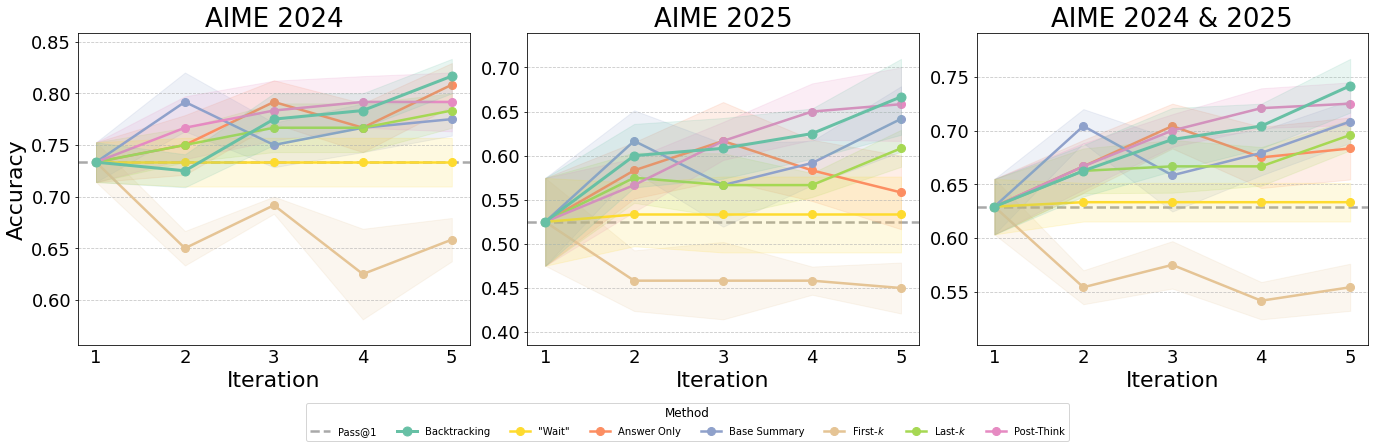


--- Generating Figure 2: Grouped Bar Plot ---
Placeholder: get_self_consistency_data called with base_dir='pass_consensus'
Error: SC data empty.

--- Summary of Results (Mean ± SEM) ---
Figure       Year Group       Method Iteration  Mean   SEM
  Fig1        AIME 2024       "Wait"         1 0.733 0.019
  Fig1        AIME 2024       "Wait"         2 0.733 0.024
  Fig1        AIME 2024       "Wait"         3 0.733 0.024
  Fig1        AIME 2024       "Wait"         4 0.733 0.024
  Fig1        AIME 2024       "Wait"         5 0.733 0.024
  Fig1        AIME 2024  Answer Only         1 0.733 0.019
  Fig1        AIME 2024  Answer Only         2 0.750 0.029
  Fig1        AIME 2024  Answer Only         3 0.792 0.021
  Fig1        AIME 2024  Answer Only         4 0.767 0.024
  Fig1        AIME 2024  Answer Only         5 0.808 0.021
  Fig1        AIME 2024 Backtracking         1 0.733 0.019
  Fig1        AIME 2024 Backtracking         2 0.725 0.016
  Fig1        AIME 2024 Backtracking         3

In [ ]:
# --- Global Plotting Configuration ---
# EXPERIMENTAL_GROUP_COLORS defines the palette for different experimental methods,
# excluding Self-Consistency and Pass@1 which have fixed colors.
EXPERIMENTAL_GROUP_COLORS = [
    '#FC8E62',  # Answer Only
    '#67C0A5',  # Backtracking
    '#8FA1CB',  # Base Summary
    '#E5C495',  # First-$k$
    '#A6D853',  # Last-$k$
    '#E68AC2', # Post-Think
    '#FEDB2F',  # "Wait"
]

METHOD_DISPLAY_NAME_MAP = {
    "backtracking": "Backtracking",
    "base_sum": "Base Summary",
    "firstk": "First-$k$",
    "lastk": "Last-$k$",
    "postThink": "Post-Think",
    "wait": '"Wait"', # Added for the new experiment
    "Self-Consistency Score": "Self-Consistency",  # Used as input label for SC line in Figure 1
    "Self-Consistency (Cond. Fractional)": "Self-Consistency", # Used as input label for SC method in Figure 2
    "Pass@1 Score": "Pass@1", # For Figure 1 line label
    "Pass@1": "Pass@1",       # For Figure 2 bar label & internal key for data,
    'answer_only': 'Answer Only'
}


# For consistent color mapping across figures
METHOD_COLOR_PALETTE = {
    # Predefined colors for specific methods (using canonical raw names as keys)
    "Self-Consistency": "dimgray",
    "Pass@1": "darkgray",        # Color for Pass@1
    # Other raw base method names (e.g., "firstk") will be populated by populate_method_colors
}
# Stores the order of methods that get colors from EXPERIMENTAL_GROUP_COLORS, for reproducibility
_OTHER_METHODS_ORDER_FOR_PALETTE = []

def get_canonical_raw_name(original_raw_name):
    """Converts various raw method names to a single canonical form for color/display mapping."""
    if original_raw_name in ["Self-Consistency Score", "Self-Consistency (Cond. Fractional)"]:
        return "Self-Consistency"
    if original_raw_name in ["Pass@1 Score", "Pass@1"]: # Handles Fig1 label and Fig2 key
        return "Pass@1"
    suffix_iter4 = " (Iter 4)"
    if original_raw_name.endswith(suffix_iter4):
        return original_raw_name[:-len(suffix_iter4)]
    return original_raw_name

def populate_method_colors(all_raw_base_experiment_types):
    """
    Populates METHOD_COLOR_PALETTE for experiment types not already defined,
    using the EXPERIMENTAL_GROUP_COLORS list.
    """
    global _OTHER_METHODS_ORDER_FOR_PALETTE, METHOD_COLOR_PALETTE, EXPERIMENTAL_GROUP_COLORS

    # Ensure predefined keys for SC and Pass@1 have their colors
    METHOD_COLOR_PALETTE.setdefault("Self-Consistency", "dimgray")
    METHOD_COLOR_PALETTE.setdefault("Pass@1", "darkgray")

    # Identify methods that need a color from the experimental group palette
    # These are methods not already in METHOD_COLOR_PALETTE (e.g., not SC or Pass@1)
    methods_needing_color = sorted([
        name for name in list(set(all_raw_base_experiment_types))
        if name not in METHOD_COLOR_PALETTE
    ])

    _OTHER_METHODS_ORDER_FOR_PALETTE = methods_needing_color

    for i, raw_base_name in enumerate(methods_needing_color):
        if i < len(EXPERIMENTAL_GROUP_COLORS):
            METHOD_COLOR_PALETTE[raw_base_name] = EXPERIMENTAL_GROUP_COLORS[i]
        else:
            # If there are more unique experiment types than colors in EXPERIMENTAL_GROUP_COLORS,
            # print a warning. These methods will default to 'gray' via get_method_color.
            print(f"Warning: Ran out of predefined experimental group colors. Method '{raw_base_name}' (and subsequent) will use default color.")
            break # Stop assigning from the limited list

def get_method_color(original_raw_name):
    """Gets the color for a given raw method name."""
    canonical_name = get_canonical_raw_name(original_raw_name)
    if canonical_name not in METHOD_COLOR_PALETTE:
        print(f"Warning: Color for method '{canonical_name}' (from '{original_raw_name}') not found. Defaulting to gray.")
        return 'gray'
    return METHOD_COLOR_PALETTE[canonical_name]

def get_display_name(original_name, for_legend_fig2=False):
    """Gets the display-friendly name for methods."""
    if original_name in METHOD_DISPLAY_NAME_MAP:
        return METHOD_DISPLAY_NAME_MAP[original_name]

    suffix_iter4 = " (Iter 4)"
    if original_name.endswith(suffix_iter4):
        base_name = original_name[:-len(suffix_iter4)]
        display_base = METHOD_DISPLAY_NAME_MAP.get(base_name, base_name)
        return display_base if for_legend_fig2 else f"{display_base}{suffix_iter4}"

    return METHOD_DISPLAY_NAME_MAP.get(original_name, original_name)

# --- Plotting Functions ---
def plot_scaling_accuracy_by_iteration(results_df, plot_title_suffix="", ax=None,
                                       self_consistency_score=None, self_consistency_label="Self-Consistency Score",
                                       pass_at_1_score=None, pass_at_1_label="Pass@1 Score", set_y_label=True): # Added set_y_label
    if results_df.empty:
        if ax: ax.text(0.5, 0.5, "No data available", ha='center', va='center')
        print(f"Input DataFrame empty for '{plot_title_suffix}'. Cannot generate scaling plot.")
        return None, None, None

    iteration_cols = [f'iteration_{i}_correct' for i in range(5)]
    required_cols = ['experiment_type', 'seed'] + iteration_cols
    if any(col not in results_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in results_df.columns]
        if ax: ax.text(0.5, 0.5, f"Missing columns:\n{', '.join(missing)}", ha='center', va='center', wrap=True)
        print(f"Missing columns: {missing} for '{plot_title_suffix}'. Cannot generate scaling plot.")
        return None, None, None

    df_to_process = results_df.copy()
    for col in iteration_cols: df_to_process[col] = pd.to_numeric(df_to_process[col], errors='coerce')

    scaling_data_intermediate = df_to_process.groupby(['experiment_type', 'seed'])[iteration_cols].mean()
    scaling_means = scaling_data_intermediate.groupby('experiment_type')[iteration_cols].mean().sort_index()
    scaling_sems = scaling_data_intermediate.groupby('experiment_type')[iteration_cols].sem().sort_index().fillna(0)

    if scaling_means.empty:
        if ax: ax.text(0.5, 0.5, "No data to plot", ha='center', va='center')
        print(f"No scaling data for '{plot_title_suffix}'.")
        return None, None, None

    if ax is None: fig, ax = plt.subplots(figsize=(12, 8))

    iteration_numbers = np.array(range(1, 6))
    all_plot_accuracies_for_ylim = []

    for exp_type in scaling_means.index:
        mean_acc = scaling_means.loc[exp_type, iteration_cols].values
        sem_val = scaling_sems.loc[exp_type, iteration_cols].values
        all_plot_accuracies_for_ylim.extend(mean_acc + sem_val); all_plot_accuracies_for_ylim.extend(mean_acc - sem_val)

        disp_label = get_display_name(exp_type); color = get_method_color(exp_type)
        lw, ms, zo = (3, 9, 3) if get_canonical_raw_name(exp_type) == 'backtracking' else (2.5, 8, 2)

        ax.plot(iteration_numbers, mean_acc, marker='o', linestyle='-', linewidth=lw, label=disp_label, color=color, markersize=ms, zorder=zo)
        ax.fill_between(iteration_numbers, mean_acc - sem_val, mean_acc + sem_val, color=color, alpha=0.15, zorder=zo - 0.5)

    if pass_at_1_score is not None and pd.notna(pass_at_1_score):
        disp_p1_label = get_display_name(pass_at_1_label); p1_color = get_method_color(pass_at_1_label)
        ax.axhline(y=pass_at_1_score, color=p1_color, linestyle='--', linewidth=2.5, label=disp_p1_label, zorder=1.4)
        all_plot_accuracies_for_ylim.append(pass_at_1_score)

    if self_consistency_score is not None and pd.notna(self_consistency_score):
        disp_sc_label = get_display_name(self_consistency_label); sc_color = get_method_color(self_consistency_label)
        ax.axhline(y=self_consistency_score, color=sc_color, linestyle=':', linewidth=2.5, label=disp_sc_label, zorder=1.5)
        all_plot_accuracies_for_ylim.append(self_consistency_score)

    ax.set_xlabel("Iteration", fontsize=22)
    if set_y_label:
        ax.set_ylabel("Accuracy", fontsize=22)
    # Else, no y-label for this plot if set_y_label is False

    ax.set_title(f"{plot_title_suffix}".strip()[1:-1], fontsize=26, fontweight='bold')
    ax.set_xticks(iteration_numbers); ax.set_xticklabels([str(it) for it in iteration_numbers], fontsize=18)


    if all_plot_accuracies_for_ylim:
        min_val, max_val = np.nanmin(all_plot_accuracies_for_ylim), np.nanmax(all_plot_accuracies_for_ylim)
        pad = (max_val - min_val) * 0.10 or 0.1
        ax.set_ylim(max(0, min_val - pad), min(1.05, max_val + pad))
    else: ax.set_ylim(0, 1.05)

    ax.tick_params(axis='y', labelsize=18); ax.tick_params(axis='x', which='major', length=0)
    ax.grid(True, linestyle='--', alpha=0.7, axis='y'); ax.grid(False, axis='x')
    return scaling_means, scaling_sems, iteration_cols

# Legend sort key for Figure 1
def legend_sort_key_fig1(label_handle_pair):
    label = label_handle_pair[0]
    if label == get_display_name("Pass@1 Score"): return (-1, label)
    if label == get_display_name("Self-Consistency Score"): return (0, label)
    if label == get_display_name("backtracking"): return (1, label)
    if label == get_display_name("wait"): return (1.1, label) # Added for "Wait"
    return (2, label)

def generate_figure_1_scaling_plots(csv_path="aggregated_iteration_grading_results_with_year.csv",
                                    self_consistency_base_dir="pass_consensus"):
    print("\n--- Generating Figure 1: Scaling Plots ---")
    fig1_table_data = []
    if not os.path.exists(csv_path):
        print(f"Error: CSV not found at {csv_path}")
        return fig1_table_data # Return empty list

    results_df = pd.read_csv(csv_path)
    if 'year' not in results_df.columns:
        results_df['year'] = results_df['problem_id'].apply(lambda x: 2024 if isinstance(x, str) and x.startswith('2024') else 2025) if 'problem_id' in results_df.columns else 0
        print("Warning: 'year' column missing, inferred or defaulted.")
    results_df['year'] = pd.to_numeric(results_df['year'], errors='coerce').fillna(0).astype(int)
    if 'seed' not in results_df.columns: results_df['seed'] = 's_unknown'; print("Warning: 'seed' column missing.")

    sc_means, sc_stats = {}, {} # sc_means for plotting, sc_stats for table
    p1_means, p1_stats = {}, {} # p1_means for plotting, p1_stats for table

    try: # SC Data
        sc_df = get_self_consistency_data(base_dir=self_consistency_base_dir)
        if not sc_df.empty:
            for yr_key, yr_val in [('2024', 2024), ('2025', 2025), ('Combined', None)]:
                df = sc_df[sc_df['base_year'] == yr_val] if yr_val is not None else sc_df
                if not df.empty:
                    s_means_series = df.groupby('seed')['self_consistent_score'].mean()
                    mean_val, sem_val = get_mean_and_sem(s_means_series) if not s_means_series.empty else (np.nan, np.nan)
                    sc_means[yr_key] = mean_val
                    sc_stats[yr_key] = {'mean': mean_val, 'sem': sem_val}
                else:
                    sc_means[yr_key] = np.nan
                    sc_stats[yr_key] = {'mean': np.nan, 'sem': np.nan}
        else: print("Warning: Self-consistency data empty.")
    except Exception as e: print(f"Warning: SC data loading/processing error ({e}).")

    try: # Pass@1 Data
        if 'iteration_0_correct' in results_df.columns:
            for yr_key, yr_val in [('2024', 2024), ('2025', 2025), ('Combined', None)]:
                df = results_df[results_df['year'] == yr_val] if yr_val is not None else results_df
                if not df.empty:
                    s_means_series = df.groupby('seed')['iteration_0_correct'].mean()
                    mean_val, sem_val = get_mean_and_sem(s_means_series) if not s_means_series.empty else (np.nan, np.nan)
                    p1_means[yr_key] = mean_val
                    p1_stats[yr_key] = {'mean': mean_val, 'sem': sem_val}
                else:
                    p1_means[yr_key] = np.nan
                    p1_stats[yr_key] = {'mean': np.nan, 'sem': np.nan}
        else: print("Warning: 'iteration_0_correct' missing for Pass@1.")
    except Exception as e: print(f"Warning: Pass@1 data processing error ({e}).")

    fig1, axes = plt.subplots(1, 3, figsize=(20, 6))
    raw_sc_lbl, raw_p1_lbl = "Self-Consistency Score", "Pass@1 Score"
    year_group_configs = [('2024', 2024, "(AIME 2024)"), ('2025', 2025, "(AIME 2025)"), ('Combined', None, "(AIME 2024 & 2025)")]

    for i, (yr_key, yr_val, title_suffix) in enumerate(year_group_configs):
        df_plot = results_df[results_df['year'] == yr_val] if yr_val is not None else results_df
        ax = axes[i]
        year_group_display_name = title_suffix.strip()[1:-1]

        if not df_plot.empty:
            iter_means_df, iter_sems_df, iter_cols_list = plot_scaling_accuracy_by_iteration(
                df_plot, plot_title_suffix=title_suffix, ax=ax,
                self_consistency_score=sc_means.get(yr_key), self_consistency_label=raw_sc_lbl,
                pass_at_1_score=p1_means.get(yr_key), pass_at_1_label=raw_p1_lbl,
                set_y_label=(i == 0) # Conditionally set y-label
            )
            if iter_means_df is not None and iter_sems_df is not None and iter_cols_list is not None:
                for exp_type in iter_means_df.index:
                    for iter_col_name in iter_cols_list:
                        iter_num = int(iter_col_name.split('_')[1])
                        fig1_table_data.append({
                            'Figure': 'Fig1',
                            'Year Group': year_group_display_name,
                            'Method': get_display_name(exp_type),
                            'Iteration': iter_num + 1,  # Start iterations at 1 instead of 0
                            'Mean': iter_means_df.loc[exp_type, iter_col_name],
                            'SEM': iter_sems_df.loc[exp_type, iter_col_name]
                        })
        else:
            ax.text(0.5,0.5,f"No data for {year_group_display_name}", ha='center',va='center',fontsize=12)
            ax.set_title(year_group_display_name, fontsize=15, fontweight='bold')
            ax.set_xlabel("Iteration Number",fontsize=13)
            if i == 0: # Only set y-label for the leftmost plot
                ax.set_ylabel("Accuracy (μ ±1 SEM)",fontsize=13)
            ax.set_ylim(0,1.05)
            if pd.notna(p1_val_plot := p1_means.get(yr_key)): ax.axhline(y=p1_val_plot, color=get_method_color(raw_p1_lbl), linestyle='--', lw=2.5, label=get_display_name(raw_p1_lbl), zorder=1.4)
            if pd.notna(sc_val_plot := sc_means.get(yr_key)): ax.axhline(y=sc_val_plot, color=get_method_color(raw_sc_lbl), linestyle=':', lw=2.5, label=get_display_name(raw_sc_lbl), zorder=1.5)

    # Add SC and P@1 data to table after all subplots are processed
    for yr_key, _, title_suffix in year_group_configs:
        year_group_display_name = title_suffix.strip()[1:-1]
        if yr_key in p1_stats and pd.notna(p1_stats[yr_key]['mean']):
            fig1_table_data.append({
                'Figure': 'Fig1', 'Year Group': year_group_display_name, 'Method': get_display_name(raw_p1_lbl),
                'Iteration': 'N/A', 'Mean': p1_stats[yr_key]['mean'], 'SEM': p1_stats[yr_key]['sem']
            })
        if yr_key in sc_stats and pd.notna(sc_stats[yr_key]['mean']):
            fig1_table_data.append({
                'Figure': 'Fig1', 'Year Group': year_group_display_name, 'Method': get_display_name(raw_sc_lbl),
                'Iteration': 'N/A', 'Mean': sc_stats[yr_key]['mean'], 'SEM': sc_stats[yr_key]['sem']
            })

    handles, labels, seen_labels = [], [], set()
    for ax_ in axes:
        if any(isinstance(c, plt.Line2D) for c in ax_.get_children()): # Check if ax has lines (data was plotted)
            h, l = ax_.get_legend_handles_labels()
            for handle, label_text in zip(h, l):
                if label_text not in seen_labels: handles.append(handle); labels.append(label_text); seen_labels.add(label_text)
    if handles:
        s_items = sorted(zip(labels, handles), key=legend_sort_key_fig1)
        s_labels, s_handles = [it[0] for it in s_items], [it[1] for it in s_items]
        # new:
        fig1.legend(
    s_handles, s_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.01),
    ncol=len(s_handles),       # ← use all entries in one row
    title="Method",
    fontsize=16,
    title_fontsize=18
)

        plt.tight_layout(rect=[0.02, 0.001, 0.98, 0.94])
    else: plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.94])
    plt.show()
    return fig1_table_data

# Legend sort key for Figure 2
def legend_sort_key_fig2(label_handle_pair):
    label, _ = label_handle_pair
    order = {
        get_display_name("Pass@1", True): -1,
        get_display_name("Self-Consistency (Cond. Fractional)", True): 0,
        get_display_name("wait (Iter 4)", True): 0.5,
        get_display_name("backtracking (Iter 4)", True): 1,
        get_display_name("postThink (Iter 4)", True): 2,
        get_display_name("base_sum (Iter 4)", True): 3,
        get_display_name("lastk (Iter 4)", True): 4,
        get_display_name("firstk (Iter 4)", True): 5
    }
    return (order.get(label, 6), label)

# --- Figure 2: Grouped Bar Graph ---
def generate_figure_2_grouped_bar_plot(
    self_consistency_base_dir="pass_consensus",
    iteration_csv_path="aggregated_iteration_grading_results_with_year.csv"):
    print("\n--- Generating Figure 2: Grouped Bar Plot ---")
    fig2_table_data = []
    try: sc_df = get_self_consistency_data(base_dir=self_consistency_base_dir)
    except Exception as e: print(f"Error loading SC data: {e}"); return fig2_table_data
    if sc_df.empty: print("Error: SC data empty."); return fig2_table_data

    sc_means, sc_sems, sc_raw_scores = {}, {}, {}
    p1_means, p1_sems, p1_raw_scores = {}, {}, {}
    raw_p1_key_fig2 = "Pass@1"

    try:
        for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
            df = sc_df[sc_df['base_year']==filt] if filt else sc_df
            sc_means[yr],sc_sems[yr],sc_raw_scores[yr]=(np.nan,np.nan,[])
            if not df.empty: s_m = df.groupby('seed')['self_consistent_score'].mean(); sc_means[yr],sc_sems[yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan); sc_raw_scores[yr]=s_m.tolist() if not s_m.empty else []
    except Exception as e: print(f"Error processing SC data: {e}"); return fig2_table_data

    if not os.path.exists(iteration_csv_path): print(f"Error: Iteration CSV not found: {iteration_csv_path}"); return fig2_table_data
    iter_df = pd.read_csv(iteration_csv_path)
    iter_df['year'] = pd.to_numeric(iter_df['year'], errors='coerce').fillna(0).astype(int)
    if 'seed' not in iter_df.columns: iter_df['seed'] = 's_unknown'; print("Warning: 'seed' missing in iter_df.")

    try:
        if 'iteration_0_correct' in iter_df.columns:
            for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                df = iter_df[iter_df['year']==filt] if filt else iter_df
                p1_means[yr],p1_sems[yr],p1_raw_scores[yr]=(np.nan,np.nan,[])
                if not df.empty: s_m = df.groupby('seed')['iteration_0_correct'].mean(); p1_means[yr],p1_sems[yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan); p1_raw_scores[yr]=s_m.tolist() if not s_m.empty else []
        else: print("Warning: 'iteration_0_correct' missing for Fig2 Pass@1.")
    except Exception as e: print(f"Error processing Pass@1 data for Fig2: {e}")

    iter_method_data = {}
    unique_exp_types = iter_df['experiment_type'].unique() if 'experiment_type' in iter_df.columns else []
    for exp_type in sorted(unique_exp_types):
        key = f"{exp_type} (Iter 4)"; iter_method_data[key] = {'means':{},'sems':{},'raw_seed_values':{}}
        try:
            for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                df = iter_df[(iter_df['experiment_type']==exp_type)&(iter_df['year']==filt)] if filt else iter_df[iter_df['experiment_type']==exp_type]
                iter_method_data[key]['means'][yr],iter_method_data[key]['sems'][yr],iter_method_data[key]['raw_seed_values'][yr]=(np.nan,np.nan,[])
                if not df.empty: s_m = df.groupby('seed')['iteration_4_correct'].mean(); iter_method_data[key]['means'][yr],iter_method_data[key]['sems'][yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan); iter_method_data[key]['raw_seed_values'][yr]=s_m.tolist() if not s_m.empty else []
        except Exception as e: print(f"Error processing iter data for {exp_type}: {e}"); break

    raw_sc_key_fig2 = "Self-Consistency (Cond. Fractional)"
    def bar_sort_key(k):
        can = get_canonical_raw_name(k)
        o = {"Pass@1": -1, "Self-Consistency": 0, "wait": 0.5, "backtracking": 1, "postThink": 2, "base_sum": 3, "lastk": 4, "firstk": 5}
        return (o.get(can, 6), can)

    all_meth_keys = sorted(list(set([raw_p1_key_fig2, raw_sc_key_fig2] + list(iter_method_data.keys()))), key=bar_sort_key)

    yrs_disp, yrs_keys = ["AIME 2024","AIME 2025","AIME 2024 & 2025"], ['2024','2025','Combined']
    n_meth, n_yrs = len(all_meth_keys), len(yrs_disp)

    fig2 = plt.figure(figsize=(max(16, n_meth*2.5+4), 10))

    # Use a single Axes object for a normal bar graph
    ax = fig2.add_subplot(111)

    bar_w_tot, x_main = 0.8, np.arange(n_yrs); bar_w = bar_w_tot/n_meth

    all_bar_means = [] # Collect all mean values to determine y-axis limit

    for i, meth_key in enumerate(all_meth_keys):
        disp_name = get_display_name(meth_key,True)
        color = get_method_color(meth_key)
        method_means_for_bar = []

        for idx, yr_k in enumerate(yrs_keys):
            current_mean, current_sem = np.nan, np.nan
            if meth_key == raw_p1_key_fig2:
                current_mean, current_sem = p1_means.get(yr_k,np.nan), p1_sems.get(yr_k,np.nan)
            elif meth_key == raw_sc_key_fig2:
                current_mean, current_sem = sc_means.get(yr_k,np.nan), sc_sems.get(yr_k,np.nan)
            else:
                d=iter_method_data.get(meth_key,{'means':{},'sems':{},'raw_seed_values':{}})
                current_mean, current_sem = d['means'].get(yr_k,np.nan), d['sems'].get(yr_k,np.nan)

            method_means_for_bar.append(current_mean)
            if pd.notna(current_mean):
                all_bar_means.append(current_mean)

            fig2_table_data.append({
                'Figure': 'Fig2', 'Year Group': yrs_disp[idx], 'Method': disp_name,
                'Iteration': 'Iter 4' if meth_key not in [raw_p1_key_fig2, raw_sc_key_fig2] and meth_key.endswith("(Iter 4)") else 'N/A',
                'Mean': current_mean, 'SEM': current_sem
            })

        bar_positions = x_main-(bar_w_tot/2)+(i*bar_w)+(bar_w/2)
        # Plot bars on the single axes
        rects = ax.bar(bar_positions, method_means_for_bar, bar_w, label=disp_name, color=color, zorder=5)

        # Modify bar labels: slightly larger font size (12), already bold
        ax.bar_label(rects, fmt='%.2f', fontweight='bold', fontsize=16, padding=3, label_type='edge', zorder=11)

    # Set y-axis to start from 0 and determine upper limit dynamically
    upper_y_limit = 0.4 # Default upper limit if no data or all data is low/NaN
    if all_bar_means:
        valid_means = [m for m in all_bar_means if pd.notna(m)]
        if valid_means:
            max_val = max(valid_means)
            # Upper limit is 10% above max value, but at least 0.4, and capped at 1.0 (for accuracy scores)
            upper_y_limit = min(1.0, max(0.4, max_val * 1.1))

    ax.set_ylim(0, upper_y_limit)

    # Standard spine visibility for a bar chart (hide top and right)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Figure-level y-axis label (kept from original for consistent placement)
    fig2.text(0.03, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=20)
    ax.set_title('Accuracy Comparison Over Methods', fontsize=26, fontweight='bold', y=1.02)

    ax.set_xticks(x_main)
    ax.set_xticklabels(yrs_disp, fontsize=20)

    # Apply tick and grid settings to the single ax
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', which='major', length=0) # Removes x-axis ticks but keeps labels
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    ax.grid(False, axis='x') # No vertical grid lines

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        unique_items_map = {label: handle for handle, label in reversed(list(zip(handles, labels)))}
        sorted_unique_items = sorted(unique_items_map.items(), key=lambda item: legend_sort_key_fig2(item))

        s_labels = [item[0] for item in sorted_unique_items]
        s_handles = [item[1] for item in sorted_unique_items]

        fig2.legend(
            s_handles, s_labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.15), # Original position for legend
            ncol=len(s_handles),
            title="Method",
            fontsize=14,
            title_fontsize=18
        )

    plt.tight_layout(rect=[0.05, 0.15, 0.97, 0.93]) # Original rect, should accommodate legend
    plt.show()
    return fig2_table_data

# --- Function to Print Results Table ---
def print_results_summary_table(all_results_data):
    if not all_results_data:
        print("\n--- No results data to display in table. ---")
        return

    print("\n--- Summary of Results (Mean ± SEM) ---")
    df = pd.DataFrame(all_results_data)

    cols = ['Figure', 'Year Group', 'Method', 'Iteration', 'Mean', 'SEM']
    df = df.dropna(subset=['Method', 'Mean', 'SEM'])
    if df.empty:
        print("\n--- No valid results data to display after filtering. ---")
        return
    df = df[cols]

    df['Mean'] = df['Mean'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    df['SEM'] = df['SEM'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    df['Iteration'] = df['Iteration'].astype(str).replace('nan', 'N/A')

    iteration_categories = [str(i+1) for i in range(5)] + ['Iter 4', 'N/A'] # Iterations 1-5, 'Iter 4', 'N/A'
    df['Iteration'] = pd.Categorical(df['Iteration'], categories=iteration_categories, ordered=True)

    df.sort_values(by=['Figure', 'Year Group', 'Method', 'Iteration'], inplace=True)

    print(df.to_string(index=False))


# --- Main Execution ---
if __name__ == '__main__':
    AGGREGATED_ITERATION_RESULTS_CSV = "aggregated_iteration_grading_results_with_year.csv"
    SELF_CONSISTENCY_DATA_DIR = "pass_consensus"

    # Imports are typically at the top of the script/notebook
    # import pandas as pd
    # import matplotlib.pyplot as plt
    # import numpy as np
    # import os
    # import json

    # Placeholder for functions assumed to be defined elsewhere in a notebook context
    # def get_self_consistency_data(base_dir):
    #     # Dummy implementation for testing if needed
    #     # print(f"Attempting to load SC data from: {base_dir}")
    #     return pd.DataFrame()
    # def get_mean_and_sem(series_data):
    #     if series_data.empty: return np.nan, np.nan
    #     return series_data.mean(), series_data.sem()


    if os.path.exists(AGGREGATED_ITERATION_RESULTS_CSV):
        try:
            df_main = pd.read_csv(AGGREGATED_ITERATION_RESULTS_CSV)
            exp_types_for_colors = df_main['experiment_type'].unique() if 'experiment_type' in df_main.columns else []
            populate_method_colors(exp_types_for_colors)
        except Exception as e:
            print(f"Error reading CSV for color pop: {e}")
            populate_method_colors([])
    else:
        print(f"Warning: CSV {AGGREGATED_ITERATION_RESULTS_CSV} not found. Color mapping incomplete.")
        populate_method_colors([])

    fig1_results = generate_figure_1_scaling_plots(
        csv_path=AGGREGATED_ITERATION_RESULTS_CSV,
        self_consistency_base_dir=SELF_CONSISTENCY_DATA_DIR
    )
    fig2_results = generate_figure_2_grouped_bar_plot(
        self_consistency_base_dir=SELF_CONSISTENCY_DATA_DIR,
        iteration_csv_path=AGGREGATED_ITERATION_RESULTS_CSV
    )

    all_plot_results = []
    if fig1_results:
        all_plot_results.extend(fig1_results)
    if fig2_results:
        all_plot_results.extend(fig2_results)

    print_results_summary_table(all_plot_results)

    print("\n--- Script Finished ---")



--- Generating Figure 1: Scaling Plots (as separate files) ---
Placeholder: get_self_consistency_data called with base_dir='pass_consensus'
Saved plot: figure_1_scaling_2024.png


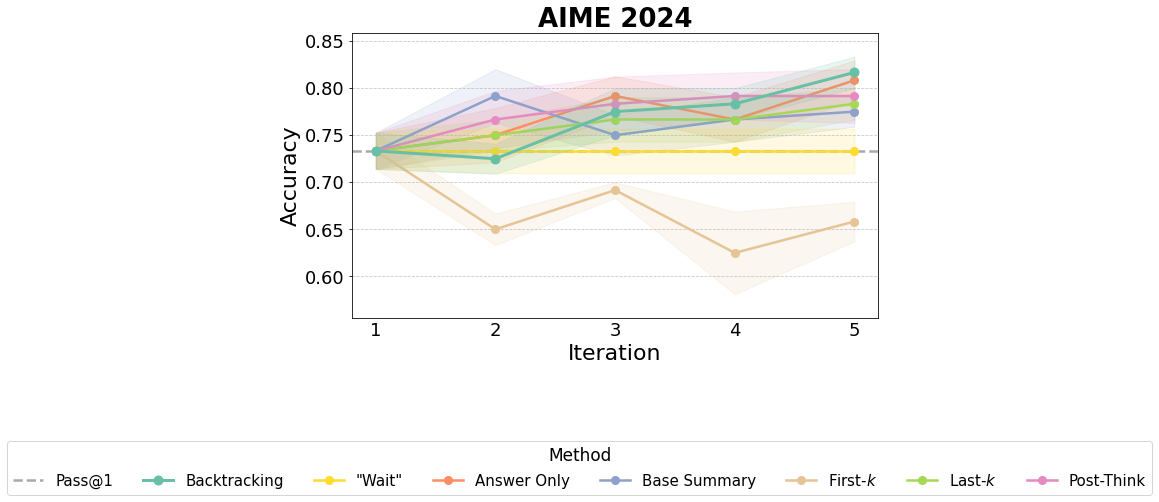

Saved plot: figure_1_scaling_2025.png


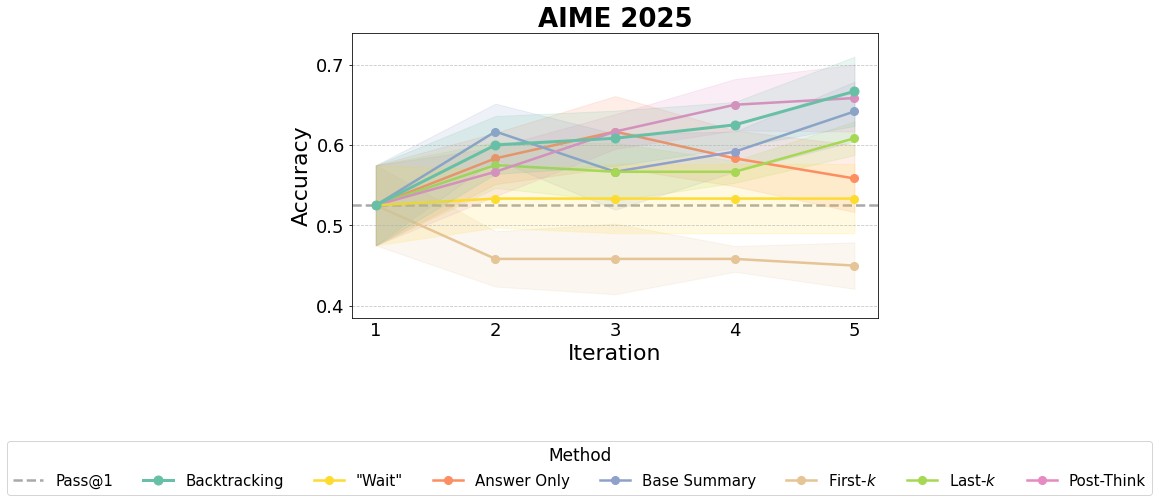

Saved plot: figure_1_scaling_combined.png


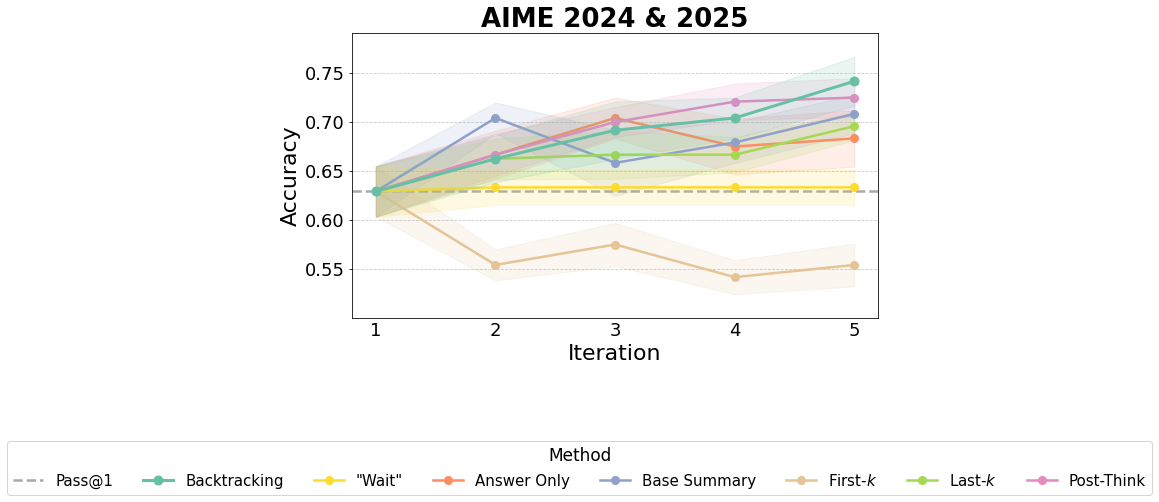


--- Generating Figure 2: Grouped Bar Plot ---
Placeholder: get_self_consistency_data called with base_dir='pass_consensus'
Error: SC data empty for Fig2.

--- Summary of Results (Mean ± SEM) ---
Figure       Year Group       Method Iteration  Mean   SEM
  Fig1        AIME 2024       "Wait"         1 0.733 0.019
  Fig1        AIME 2024       "Wait"         2 0.733 0.024
  Fig1        AIME 2024       "Wait"         3 0.733 0.024
  Fig1        AIME 2024       "Wait"         4 0.733 0.024
  Fig1        AIME 2024       "Wait"         5 0.733 0.024
  Fig1        AIME 2024  Answer Only         1 0.733 0.019
  Fig1        AIME 2024  Answer Only         2 0.750 0.029
  Fig1        AIME 2024  Answer Only         3 0.792 0.021
  Fig1        AIME 2024  Answer Only         4 0.767 0.024
  Fig1        AIME 2024  Answer Only         5 0.808 0.021
  Fig1        AIME 2024 Backtracking         1 0.733 0.019
  Fig1        AIME 2024 Backtracking         2 0.725 0.016
  Fig1        AIME 2024 Backtracking 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json # Though not directly used in the changed part, it might be in get_self_consistency_data

# --- Global Plotting Configuration ---
# EXPERIMENTAL_GROUP_COLORS defines the palette for different experimental methods,
# excluding Self-Consistency and Pass@1 which have fixed colors.
EXPERIMENTAL_GROUP_COLORS = [
    '#FC8E62',  # Answer Only
    '#67C0A5',  # Backtracking
    '#8FA1CB',  # Base Summary
    '#E5C495',  # First-$k$
    '#A6D853',  # Last-$k$
    '#E68AC2', # Post-Think
    '#FEDB2F',  # "Wait"
]

METHOD_DISPLAY_NAME_MAP = {
    "backtracking": "Backtracking",
    "base_sum": "Base Summary",
    "firstk": "First-$k$",
    "lastk": "Last-$k$",
    "postThink": "Post-Think",
    "wait": '"Wait"', # Added for the new experiment
    "Self-Consistency Score": "Self-Consistency",  # Used as input label for SC line in Figure 1
    "Self-Consistency (Cond. Fractional)": "Self-Consistency", # Used as input label for SC method in Figure 2
    "Pass@1 Score": "Pass@1", # For Figure 1 line label
    "Pass@1": "Pass@1",       # For Figure 2 bar label & internal key for data,
    'answer_only': 'Answer Only'
}


# For consistent color mapping across figures
METHOD_COLOR_PALETTE = {
    # Predefined colors for specific methods (using canonical raw names as keys)
    "Self-Consistency": "dimgray",
    "Pass@1": "darkgray",        # Color for Pass@1
    # Other raw base method names (e.g., "firstk") will be populated by populate_method_colors
}
# Stores the order of methods that get colors from EXPERIMENTAL_GROUP_COLORS, for reproducibility
_OTHER_METHODS_ORDER_FOR_PALETTE = []

def get_canonical_raw_name(original_raw_name):
    """Converts various raw method names to a single canonical form for color/display mapping."""
    if original_raw_name in ["Self-Consistency Score", "Self-Consistency (Cond. Fractional)"]:
        return "Self-Consistency"
    if original_raw_name in ["Pass@1 Score", "Pass@1"]: # Handles Fig1 label and Fig2 key
        return "Pass@1"
    suffix_iter4 = " (Iter 4)"
    if original_raw_name.endswith(suffix_iter4):
        return original_raw_name[:-len(suffix_iter4)]
    return original_raw_name

def populate_method_colors(all_raw_base_experiment_types):
    """
    Populates METHOD_COLOR_PALETTE for experiment types not already defined,
    using the EXPERIMENTAL_GROUP_COLORS list.
    """
    global _OTHER_METHODS_ORDER_FOR_PALETTE, METHOD_COLOR_PALETTE, EXPERIMENTAL_GROUP_COLORS

    # Ensure predefined keys for SC and Pass@1 have their colors
    METHOD_COLOR_PALETTE.setdefault("Self-Consistency", "dimgray")
    METHOD_COLOR_PALETTE.setdefault("Pass@1", "darkgray")

    # Identify methods that need a color from the experimental group palette
    # These are methods not already in METHOD_COLOR_PALETTE (e.g., not SC or Pass@1)
    # Make sure all_raw_base_experiment_types contains strings
    processed_exp_types = [str(name) for name in list(set(all_raw_base_experiment_types)) if pd.notna(name)]

    methods_needing_color = sorted([
        name for name in processed_exp_types
        if name not in METHOD_COLOR_PALETTE
    ])
    
    _OTHER_METHODS_ORDER_FOR_PALETTE = methods_needing_color

    for i, raw_base_name in enumerate(methods_needing_color):
        if i < len(EXPERIMENTAL_GROUP_COLORS):
            METHOD_COLOR_PALETTE[raw_base_name] = EXPERIMENTAL_GROUP_COLORS[i]
        else:
            # If there are more unique experiment types than colors in EXPERIMENTAL_GROUP_COLORS,
            # print a warning. These methods will default to 'gray' via get_method_color.
            print(f"Warning: Ran out of predefined experimental group colors. Method '{raw_base_name}' (and subsequent) will use default color.")
            break # Stop assigning from the limited list

def get_method_color(original_raw_name):
    """Gets the color for a given raw method name."""
    canonical_name = get_canonical_raw_name(original_raw_name)
    if canonical_name not in METHOD_COLOR_PALETTE:
        # Special handling for predefined names if populate_method_colors wasn't run or missed them
        if canonical_name == "Self-Consistency":
            METHOD_COLOR_PALETTE[canonical_name] = "dimgray"
            return "dimgray"
        if canonical_name == "Pass@1":
            METHOD_COLOR_PALETTE[canonical_name] = "darkgray"
            return "darkgray"
        # If still not found, it might be a new method not in EXPERIMENTAL_GROUP_COLORS
        # Check if it needs to be added to _OTHER_METHODS_ORDER_FOR_PALETTE (if not already)
        # and if there's a color available. For now, default to gray if truly unknown.
        print(f"Warning: Color for method '{canonical_name}' (from '{original_raw_name}') not found in METHOD_COLOR_PALETTE. Defaulting to gray.")
        return 'gray'
    return METHOD_COLOR_PALETTE[canonical_name]

def get_display_name(original_name, for_legend_fig2=False):
    """Gets the display-friendly name for methods."""
    if original_name in METHOD_DISPLAY_NAME_MAP:
        return METHOD_DISPLAY_NAME_MAP[original_name]

    suffix_iter4 = " (Iter 4)"
    if original_name.endswith(suffix_iter4):
        base_name = original_name[:-len(suffix_iter4)]
        display_base = METHOD_DISPLAY_NAME_MAP.get(base_name, base_name)
        return display_base if for_legend_fig2 else f"{display_base}{suffix_iter4}"

    return METHOD_DISPLAY_NAME_MAP.get(original_name, original_name)

# --- Plotting Functions ---
def plot_scaling_accuracy_by_iteration(results_df, plot_title_suffix="", ax=None,
                                       self_consistency_score=None, self_consistency_label="Self-Consistency Score",
                                       pass_at_1_score=None, pass_at_1_label="Pass@1 Score", set_y_label=True):
    # Basic setup for the axis, regardless of data presence
    if ax:
        ax.set_title(f"{plot_title_suffix}".strip()[1:-1] if plot_title_suffix else "Scaling Plot", fontsize=26, fontweight='bold')
        if set_y_label: ax.set_ylabel("Accuracy", fontsize=22)
        ax.set_xlabel("Iteration", fontsize=22)
        ax.set_ylim(0, 1.05) # Default Y limits
        iteration_numbers_axis = np.array(range(1, 6)) # For x-axis ticks
        ax.set_xticks(iteration_numbers_axis); ax.set_xticklabels([str(it) for it in iteration_numbers_axis], fontsize=18)
        ax.tick_params(axis='y', labelsize=18); ax.tick_params(axis='x', which='major', length=0)
        ax.grid(True, linestyle='--', alpha=0.7, axis='y'); ax.grid(False, axis='x')

    if results_df.empty:
        if ax: ax.text(0.5, 0.5, "No data available", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        print(f"Input DataFrame empty for '{plot_title_suffix}'. Cannot generate scaling plot.")
        return None, None, None

    iteration_cols = [f'iteration_{i}_correct' for i in range(5)]
    required_cols_check = ['experiment_type', 'seed']
    if any(col not in results_df.columns for col in required_cols_check):
        missing = [col for col in required_cols_check if col not in results_df.columns]
        if ax: ax.text(0.5, 0.5, f"Missing columns:\n{', '.join(missing)}", ha='center', va='center', wrap=True, fontsize=12, transform=ax.transAxes)
        print(f"Missing columns: {missing} for '{plot_title_suffix}'. Cannot generate scaling plot.")
        return None, None, None

    df_to_process = results_df.copy()
    for col in iteration_cols: 
        if col in df_to_process.columns:
            df_to_process[col] = pd.to_numeric(df_to_process[col], errors='coerce')
        else:
            df_to_process[col] = np.nan # Add missing iteration columns as NaN

    valid_iteration_cols_in_df = [col for col in iteration_cols if col in df_to_process.columns and df_to_process[col].notna().any()]
    if not valid_iteration_cols_in_df:
        if ax: ax.text(0.5, 0.5, "No iteration data to plot", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        print(f"No valid iteration columns with data found for '{plot_title_suffix}'.")
        # Still plot SC/P@1 lines if they exist
        if pass_at_1_score is not None and pd.notna(pass_at_1_score) and ax:
            ax.axhline(y=pass_at_1_score, color=get_method_color(pass_at_1_label), linestyle='--', linewidth=2.5, label=get_display_name(pass_at_1_label), zorder=1.4)
        if self_consistency_score is not None and pd.notna(self_consistency_score) and ax:
            ax.axhline(y=self_consistency_score, color=get_method_color(self_consistency_label), linestyle=':', linewidth=2.5, label=get_display_name(self_consistency_label), zorder=1.5)
        return None, None, iteration_cols # Return iteration_cols for table structure

    # Group by experiment_type and seed, then calculate mean for valid iteration columns
    # Then, group by experiment_type to get final mean and sem
    scaling_data_intermediate = df_to_process.groupby(['experiment_type', 'seed'])[valid_iteration_cols_in_df].mean()
    scaling_means = scaling_data_intermediate.groupby('experiment_type')[valid_iteration_cols_in_df].mean().reindex(columns=iteration_cols).sort_index()
    scaling_sems = scaling_data_intermediate.groupby('experiment_type')[valid_iteration_cols_in_df].sem().reindex(columns=iteration_cols).sort_index().fillna(0)
    
    if scaling_means.empty and not (pass_at_1_score is not None and pd.notna(pass_at_1_score)) and not (self_consistency_score is not None and pd.notna(self_consistency_score)):
        if ax: ax.text(0.5, 0.5, "No data to plot after grouping", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        print(f"No scaling data for '{plot_title_suffix}' after grouping and no SC/P1 lines.")
        return None, None, iteration_cols

    iteration_numbers_plot = np.array(range(1, len(iteration_cols) + 1))
    all_plot_accuracies_for_ylim = []

    for exp_type in scaling_means.index:
        if scaling_means.loc[exp_type, iteration_cols].notna().any():
            mean_acc = scaling_means.loc[exp_type, iteration_cols].values
            sem_val = scaling_sems.loc[exp_type, iteration_cols].values
            
            valid_indices = ~np.isnan(mean_acc)
            if not np.any(valid_indices): continue

            iter_nums_current_plot = iteration_numbers_plot[valid_indices]
            mean_acc_plot = mean_acc[valid_indices]
            sem_val_plot = sem_val[valid_indices]

            all_plot_accuracies_for_ylim.extend(mean_acc_plot + sem_val_plot); all_plot_accuracies_for_ylim.extend(mean_acc_plot - sem_val_plot)

            disp_label = get_display_name(exp_type); color = get_method_color(exp_type)
            lw, ms, zo = (3, 9, 3) if get_canonical_raw_name(exp_type) == 'backtracking' else (2.5, 8, 2)

            ax.plot(iter_nums_current_plot, mean_acc_plot, marker='o', linestyle='-', linewidth=lw, label=disp_label, color=color, markersize=ms, zorder=zo)
            ax.fill_between(iter_nums_current_plot, mean_acc_plot - sem_val_plot, mean_acc_plot + sem_val_plot, color=color, alpha=0.15, zorder=zo - 0.5)

    if pass_at_1_score is not None and pd.notna(pass_at_1_score):
        disp_p1_label = get_display_name(pass_at_1_label); p1_color = get_method_color(pass_at_1_label)
        ax.axhline(y=pass_at_1_score, color=p1_color, linestyle='--', linewidth=2.5, label=disp_p1_label, zorder=1.4)
        all_plot_accuracies_for_ylim.append(pass_at_1_score)

    if self_consistency_score is not None and pd.notna(self_consistency_score):
        disp_sc_label = get_display_name(self_consistency_label); sc_color = get_method_color(self_consistency_label)
        ax.axhline(y=self_consistency_score, color=sc_color, linestyle=':', linewidth=2.5, label=disp_sc_label, zorder=1.5)
        all_plot_accuracies_for_ylim.append(self_consistency_score)

    valid_ylim_values = [val for val in all_plot_accuracies_for_ylim if pd.notna(val)]
    if valid_ylim_values:
        min_val, max_val = np.nanmin(valid_ylim_values), np.nanmax(valid_ylim_values)
        pad = (max_val - min_val) * 0.10
        if pad == 0 and max_val == min_val : pad = 0.1 # Handle case where min_val = max_val
        ax.set_ylim(max(0, min_val - pad), min(1.05, max_val + pad))
    # ax.set_ylim already set at the beginning, this refines it if data exists.
    
    return scaling_means, scaling_sems, iteration_cols

# Legend sort key for Figure 1
def legend_sort_key_fig1(label_handle_pair):
    label = label_handle_pair[0]
    if label == get_display_name("Pass@1 Score"): return (-1, label)
    if label == get_display_name("Self-Consistency Score"): return (0, label)
    if label == get_display_name("backtracking"): return (1, label)
    if label == get_display_name("wait"): return (1.1, label)
    
    # Try to order other known methods based on _OTHER_METHODS_ORDER_FOR_PALETTE
    # Convert _OTHER_METHODS_ORDER_FOR_PALETTE to display names for matching
    known_others_display_ordered = [get_display_name(m) for m in _OTHER_METHODS_ORDER_FOR_PALETTE 
                                    if get_display_name(m) not in [get_display_name("backtracking"), get_display_name("wait")]]
    try:
        # Start order after "wait"
        return (1.2 + known_others_display_ordered.index(label), label)
    except ValueError:
        # Place any other unknown methods at the end
        return (1.2 + len(known_others_display_ordered), label)


def generate_figure_1_scaling_plots(csv_path="aggregated_iteration_grading_results_with_year.csv",
                                    self_consistency_base_dir="pass_consensus"):
    print("\n--- Generating Figure 1: Scaling Plots (as separate files) ---")
    fig1_table_data = []
    if not os.path.exists(csv_path):
        print(f"Error: CSV not found at {csv_path}")
        return fig1_table_data

    try:
        results_df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV {csv_path}: {e}")
        return fig1_table_data
        
    # Ensure 'experiment_type' is present for populate_method_colors
    if 'experiment_type' in results_df.columns:
        exp_types_for_colors = results_df['experiment_type'].unique()
        populate_method_colors(exp_types_for_colors) # Populate colors based on data
    else:
        print("Warning: 'experiment_type' column not found in CSV. Color mapping might be incomplete.")
        populate_method_colors([])


    if 'year' not in results_df.columns:
        if 'problem_id' in results_df.columns:
            results_df['year'] = results_df['problem_id'].astype(str).apply(lambda x: 2024 if x.startswith('2024') else (2025 if x.startswith('2025') else 0))
            print("Warning: 'year' column missing, inferred from 'problem_id' or defaulted to 0.")
        else:
            results_df['year'] = 0
            print("Warning: 'year' and 'problem_id' columns missing. 'year' defaulted to 0.")
    results_df['year'] = pd.to_numeric(results_df['year'], errors='coerce').fillna(0).astype(int)
    if 'seed' not in results_df.columns: results_df['seed'] = 's_unknown'; print("Warning: 'seed' column missing, defaulted to 's_unknown'.")

    sc_means, sc_stats = {}, {}
    p1_means, p1_stats = {}, {}

    try: 
        sc_df_raw = get_self_consistency_data(base_dir=self_consistency_base_dir)
        if not sc_df_raw.empty and 'base_year' in sc_df_raw.columns and 'self_consistent_score' in sc_df_raw.columns and 'seed' in sc_df_raw.columns:
            sc_df_raw['base_year'] = pd.to_numeric(sc_df_raw['base_year'], errors='coerce').fillna(0).astype(int)
            for yr_key, yr_val in [('2024', 2024), ('2025', 2025), ('Combined', None)]:
                df_filt = sc_df_raw[sc_df_raw['base_year'] == yr_val] if yr_val is not None else sc_df_raw
                if not df_filt.empty:
                    s_means_series = df_filt.groupby('seed')['self_consistent_score'].mean()
                    mean_val, sem_val = get_mean_and_sem(s_means_series) if not s_means_series.empty else (np.nan, np.nan)
                    sc_means[yr_key], sc_stats[yr_key] = mean_val, {'mean': mean_val, 'sem': sem_val}
                else: sc_means[yr_key], sc_stats[yr_key] = np.nan, {'mean': np.nan, 'sem': np.nan}
        else: 
            print("Warning: Self-consistency data empty or missing required columns (base_year, self_consistent_score, seed). SC scores will be NaN for all groups.")
            for yr_key, _ in [('2024',0), ('2025',0), ('Combined',0)]: sc_means[yr_key], sc_stats[yr_key] = np.nan, {'mean': np.nan, 'sem': np.nan}
    except Exception as e: 
        print(f"Warning: SC data loading/processing error ({e}). SC scores will be NaN for all groups.")
        for yr_key, _ in [('2024',0), ('2025',0), ('Combined',0)]: sc_means[yr_key], sc_stats[yr_key] = np.nan, {'mean': np.nan, 'sem': np.nan}


    try: 
        if 'iteration_0_correct' in results_df.columns:
            for yr_key, yr_val in [('2024', 2024), ('2025', 2025), ('Combined', None)]:
                df_filt = results_df[results_df['year'] == yr_val] if yr_val is not None else results_df
                if not df_filt.empty:
                    s_means_series = df_filt.groupby('seed')['iteration_0_correct'].mean()
                    mean_val, sem_val = get_mean_and_sem(s_means_series) if not s_means_series.empty else (np.nan, np.nan)
                    p1_means[yr_key], p1_stats[yr_key] = mean_val, {'mean': mean_val, 'sem': sem_val}
                else: p1_means[yr_key], p1_stats[yr_key] = np.nan, {'mean': np.nan, 'sem': np.nan}
        else: 
            print("Warning: 'iteration_0_correct' missing for Pass@1. P@1 scores will be NaN for all groups.")
            for yr_key, _ in [('2024',0), ('2025',0), ('Combined',0)]: p1_means[yr_key], p1_stats[yr_key] = np.nan, {'mean': np.nan, 'sem': np.nan}
    except Exception as e: 
        print(f"Warning: Pass@1 data processing error ({e}). P@1 scores will be NaN for all groups.")
        for yr_key, _ in [('2024',0), ('2025',0), ('Combined',0)]: p1_means[yr_key], p1_stats[yr_key] = np.nan, {'mean': np.nan, 'sem': np.nan}


    raw_sc_lbl, raw_p1_lbl = "Self-Consistency Score", "Pass@1 Score"
    year_group_configs = [('2024', 2024, "(AIME 2024)"), ('2025', 2025, "(AIME 2025)"), ('Combined', None, "(AIME 2024 & 2025)")]

    for i, (yr_key, yr_val, title_suffix) in enumerate(year_group_configs):
        fig, ax = plt.subplots(figsize=(10, 7.5)) # Increased width for legend, height for overall look
        
        df_plot_current_group = results_df[results_df['year'] == yr_val].copy() if yr_val is not None else results_df.copy()
        if 'experiment_type' not in df_plot_current_group.columns and not df_plot_current_group.empty:
            df_plot_current_group['experiment_type'] = 'unknown_exp_type' # Add if missing
            print(f"Warning: 'experiment_type' column missing in data for {title_suffix}. Defaulted for plotting.")

        year_group_display_name = title_suffix.strip()[1:-1]

        iter_means_df, iter_sems_df, iter_cols_list = plot_scaling_accuracy_by_iteration(
            df_plot_current_group, plot_title_suffix=title_suffix, ax=ax,
            self_consistency_score=sc_means.get(yr_key, np.nan), self_consistency_label=raw_sc_lbl,
            pass_at_1_score=p1_means.get(yr_key, np.nan), pass_at_1_label=raw_p1_lbl,
            set_y_label=True 
        )
        
        # Populate table data
        if iter_means_df is not None and iter_sems_df is not None and iter_cols_list is not None:
            for exp_type in iter_means_df.index:
                if iter_means_df.loc[exp_type].notna().any(): # Only add to table if there's some data
                    for iter_col_name in iter_cols_list:
                        iter_num = int(iter_col_name.split('_')[1])
                        fig1_table_data.append({
                            'Figure': 'Fig1', 
                            'Year Group': year_group_display_name,
                            'Method': get_display_name(exp_type), # Use display name
                            'Iteration': iter_num + 1, 
                            'Mean': iter_means_df.loc[exp_type, iter_col_name], # This can be NaN
                            'SEM': iter_sems_df.loc[exp_type, iter_col_name]    # This can be NaN
                        })
        
        handles, labels = ax.get_legend_handles_labels()
        if handles: # Only create legend if there are items
            # Create unique legend items, preferring the last seen (handles from ax should be unique by label already)
            unique_legend_items_map = {label: handle for handle, label in zip(handles, labels)}
            
            # Sort items for the legend using the defined sort key
            s_items = sorted(unique_legend_items_map.items(), key=lambda x: legend_sort_key_fig1((x[0], x[1])))
            s_labels = [item[0] for item in s_items]
            s_handles = [item[1] for item in s_items]

            if s_handles: # If after filtering and sorting there are still items
                fig.legend(
                    s_handles, s_labels,
                    loc='upper center',      # Anchor point of the legend Bbox
                    bbox_to_anchor=(0.5, 0.09), # Position: fig horizontal center, low on fig (y=0 means bottom)
                    ncol=len(s_handles),   # Original: all items in one row if possible
                    title="Method",
                    fontsize=12,           # Changed from 15
                    title_fontsize=14      # Changed from 17
                )
                # Adjust layout: [left, bottom, right, top] in normalized figure coordinates
                # Bottom margin needs to be large enough for the legend.
                # Top margin for the main plot title.
                plt.tight_layout(rect=[0.07, 0.20, 0.93, 0.90]) # Increased bottom, reduced top slightly
            else: # No legend items after filtering/sorting
                plt.tight_layout(rect=[0.07, 0.05, 0.93, 0.90]) # Default tight layout, less bottom space
        else: # No handles from ax.get_legend_handles_labels()
             plt.tight_layout(rect=[0.07, 0.05, 0.93, 0.90]) 

        plot_filename_base = yr_key.lower().replace('(', '').replace(')', '').replace('&', 'and').replace(' ', '_')
        plot_filename = f"figure_1_scaling_{plot_filename_base}.png"
        try:
            plt.savefig(plot_filename)
            print(f"Saved plot: {plot_filename}")
        except Exception as e:
            print(f"Error saving plot {plot_filename}: {e}")
        plt.show() # Display the plot
        plt.close(fig) # Close the figure to free memory

    # Add SC and P@1 summary data to table (same logic as before)
    for yr_key, _, title_suffix_for_table in year_group_configs:
        year_group_display_name_for_table = title_suffix_for_table.strip()[1:-1]
        if yr_key in p1_stats and pd.notna(p1_stats[yr_key].get('mean')): # Check if mean exists
            fig1_table_data.append({
                'Figure': 'Fig1', 'Year Group': year_group_display_name_for_table, 
                'Method': get_display_name(raw_p1_lbl), # Use display name
                'Iteration': 'N/A', 
                'Mean': p1_stats[yr_key]['mean'], 
                'SEM': p1_stats[yr_key]['sem']
            })
        if yr_key in sc_stats and pd.notna(sc_stats[yr_key].get('mean')): # Check if mean exists
            fig1_table_data.append({
                'Figure': 'Fig1', 'Year Group': year_group_display_name_for_table, 
                'Method': get_display_name(raw_sc_lbl), # Use display name
                'Iteration': 'N/A', 
                'Mean': sc_stats[yr_key]['mean'], 
                'SEM': sc_stats[yr_key]['sem']
            })
    return fig1_table_data

# --- Placeholder functions (user should have their own implementations) ---
def get_self_consistency_data(base_dir):
    print(f"Placeholder: get_self_consistency_data called with base_dir='{base_dir}'")
    # Return an empty DataFrame with expected columns to avoid downstream errors if function is missing
    # In a real scenario, this would load data from CSVs/JSONs in base_dir
    return pd.DataFrame(columns=['base_year', 'self_consistent_score', 'seed', 'problem_id'])

def get_mean_and_sem(series_data):
    if series_data is None or not isinstance(series_data, pd.Series) or series_data.empty:
        return np.nan, np.nan
    
    # Drop NaN values for calculation, as mean() and sem() handle them but count for sem matters
    cleaned_series = series_data.dropna()
    if cleaned_series.empty:
        return np.nan, np.nan
        
    mean = cleaned_series.mean()
    # SEM is std / sqrt(n). Pandas sem() handles this.
    # sem() returns NaN if less than 1 observation, or 0 if 1 observation.
    # For meaningful SEM, we usually want n >= 2.
    sem = cleaned_series.sem() if len(cleaned_series) >= 1 else np.nan # sem() is robust
    
    return mean, sem

# --- Figure 2: Grouped Bar Graph ---
# (Keep existing legend_sort_key_fig2 and generate_figure_2_grouped_bar_plot)
def legend_sort_key_fig2(label_handle_pair):
    label, _ = label_handle_pair
    order = {
        get_display_name("Pass@1", True): -1,
        get_display_name("Self-Consistency (Cond. Fractional)", True): 0,
        get_display_name("wait (Iter 4)", True): 0.5,
        get_display_name("backtracking (Iter 4)", True): 1,
        get_display_name("postThink (Iter 4)", True): 2,
        get_display_name("base_sum (Iter 4)", True): 3,
        get_display_name("lastk (Iter 4)", True): 4,
        get_display_name("firstk (Iter 4)", True): 5
    }
    return (order.get(label, 6), label)

def generate_figure_2_grouped_bar_plot(
    self_consistency_base_dir="pass_consensus",
    iteration_csv_path="aggregated_iteration_grading_results_with_year.csv"):
    # This function remains unchanged from your original snippet
    print("\n--- Generating Figure 2: Grouped Bar Plot ---")
    fig2_table_data = []
    try: sc_df = get_self_consistency_data(base_dir=self_consistency_base_dir)
    except Exception as e: print(f"Error loading SC data: {e}"); return fig2_table_data
    if sc_df.empty: print("Error: SC data empty for Fig2."); return fig2_table_data

    # Ensure 'experiment_type' is present in iteration_csv_path for populate_method_colors
    if os.path.exists(iteration_csv_path):
        try:
            iter_df_for_color_check = pd.read_csv(iteration_csv_path)
            if 'experiment_type' in iter_df_for_color_check.columns:
                exp_types_for_colors = iter_df_for_color_check['experiment_type'].unique()
                populate_method_colors(exp_types_for_colors) # Populate colors based on data
            else:
                # If not here, populate_method_colors might have run in Fig1 gen or main
                pass # populate_method_colors should be robust
        except Exception as e:
            print(f"Fig2: Error reading {iteration_csv_path} for color pre-check: {e}")
    else:
        print(f"Fig2: Iteration CSV {iteration_csv_path} not found for color pre-check.")


    sc_means, sc_sems, sc_raw_scores = {}, {}, {}
    p1_means, p1_sems, p1_raw_scores = {}, {}, {}
    raw_p1_key_fig2 = "Pass@1" # Internal key

    try:
        if 'base_year' in sc_df.columns and 'self_consistent_score' in sc_df.columns and 'seed' in sc_df.columns:
            sc_df['base_year'] = pd.to_numeric(sc_df['base_year'], errors='coerce').fillna(0).astype(int)
            for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                df = sc_df[sc_df['base_year']==filt] if filt is not None else sc_df
                sc_means[yr],sc_sems[yr],sc_raw_scores[yr]=(np.nan,np.nan,[])
                if not df.empty: 
                    s_m = df.groupby('seed')['self_consistent_score'].mean()
                    sc_means[yr],sc_sems[yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan)
                    sc_raw_scores[yr]=s_m.tolist() if not s_m.empty else []
        else:
            print("Fig2 SC Data Warning: Missing crucial columns (base_year, self_consistent_score, seed).")
            for yr in ['2024', '2025', 'Combined']: sc_means[yr],sc_sems[yr],sc_raw_scores[yr]=(np.nan,np.nan,[])

    except Exception as e: print(f"Error processing SC data for Fig2: {e}"); return fig2_table_data


    if not os.path.exists(iteration_csv_path): print(f"Error: Iteration CSV not found for Fig2: {iteration_csv_path}"); return fig2_table_data
    try:
        iter_df = pd.read_csv(iteration_csv_path)
        iter_df['year'] = pd.to_numeric(iter_df.get('year'), errors='coerce').fillna(0).astype(int) # Use .get for safety
        if 'seed' not in iter_df.columns: iter_df['seed'] = 's_unknown'; print("Warning: 'seed' missing in iter_df for Fig2.")
    except Exception as e:
        print(f"Error reading iteration_csv_path for Fig2: {e}")
        return fig2_table_data

    try:
        if 'iteration_0_correct' in iter_df.columns:
            for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                df = iter_df[iter_df['year']==filt] if filt is not None else iter_df
                p1_means[yr],p1_sems[yr],p1_raw_scores[yr]=(np.nan,np.nan,[])
                if not df.empty: 
                    s_m = df.groupby('seed')['iteration_0_correct'].mean()
                    p1_means[yr],p1_sems[yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan)
                    p1_raw_scores[yr]=s_m.tolist() if not s_m.empty else []
        else: 
            print("Warning: 'iteration_0_correct' missing for Fig2 Pass@1.")
            for yr in ['2024', '2025', 'Combined']: p1_means[yr],p1_sems[yr],p1_raw_scores[yr]=(np.nan,np.nan,[])
    except Exception as e: print(f"Error processing Pass@1 data for Fig2: {e}")

    iter_method_data = {}
    # Ensure 'experiment_type' and 'iteration_4_correct' exist
    if 'experiment_type' in iter_df.columns and 'iteration_4_correct' in iter_df.columns:
        unique_exp_types = iter_df['experiment_type'].dropna().unique()
        for exp_type in sorted(unique_exp_types):
            key = f"{exp_type} (Iter 4)"; iter_method_data[key] = {'means':{},'sems':{},'raw_seed_values':{}}
            try:
                for yr, filt in [('2024',2024), ('2025',2025), ('Combined',None)]:
                    df_exp_filt = iter_df[iter_df['experiment_type']==exp_type]
                    df = df_exp_filt[df_exp_filt['year']==filt] if filt is not None else df_exp_filt
                    
                    iter_method_data[key]['means'][yr],iter_method_data[key]['sems'][yr],iter_method_data[key]['raw_seed_values'][yr]=(np.nan,np.nan,[])
                    if not df.empty: 
                        s_m = df.groupby('seed')['iteration_4_correct'].mean()
                        iter_method_data[key]['means'][yr],iter_method_data[key]['sems'][yr]=get_mean_and_sem(s_m) if not s_m.empty else (np.nan,np.nan)
                        iter_method_data[key]['raw_seed_values'][yr]=s_m.tolist() if not s_m.empty else []
            except Exception as e: print(f"Error processing iter data for {exp_type} in Fig2: {e}"); # Continue with other types
    else:
        print("Warning: 'experiment_type' or 'iteration_4_correct' missing in iter_df for Fig2. Iteration method data will be empty.")


    raw_sc_key_fig2 = "Self-Consistency (Cond. Fractional)" # Internal key
    def bar_sort_key(k): # Key for sorting bars
        # Use canonical name for sorting logic, but k is the full display name with (Iter 4)
        # This sort key logic needs to map display names back to raw/canonical for ordering
        # Or, get_display_name(..., for_legend_fig2=True) might be what we need if the map keys are like that
        
        # Let's try to map k (which can be "method (Iter 4)") to its base for sorting
        base_k_for_sort = k
        suffix_iter4 = " (Iter 4)"
        if k.endswith(suffix_iter4):
            base_k_for_sort = k[:-len(suffix_iter4)]
        
        # Attempt to find a canonical name for sorting if base_k_for_sort is a raw name
        # This is a bit convoluted; the original sort relied on specific map keys
        # For simplicity here, we use the direct k if it's P@1 or SC, else the base_k_for_sort
        sortable_name_for_order = base_k_for_sort
        if k == get_display_name(raw_p1_key_fig2, True): # "Pass@1"
             sortable_name_for_order = "Pass@1"
        elif k == get_display_name(raw_sc_key_fig2, True): # "Self-Consistency"
             sortable_name_for_order = "Self-Consistency"


        o = {"Pass@1": -1, "Self-Consistency": 0, "wait": 0.5, "backtracking": 1, "postThink": 2, "base_sum": 3, "lastk": 4, "firstk": 5}
        return (o.get(sortable_name_for_order, 6), k) # Sort by order, then by original key `k`

    # Collect all method keys that will actually have data to plot or appear in legend
    all_meth_keys_with_data = []
    if p1_means: all_meth_keys_with_data.append(get_display_name(raw_p1_key_fig2, True)) # "Pass@1"
    if sc_means: all_meth_keys_with_data.append(get_display_name(raw_sc_key_fig2, True)) # "Self-Consistency"
    all_meth_keys_with_data.extend(iter_method_data.keys())
    
    all_meth_keys = sorted(list(set(all_meth_keys_with_data)), key=bar_sort_key)


    yrs_disp, yrs_keys = ["AIME 2024","AIME 2025","AIME 2024 & 2025"], ['2024','2025','Combined']
    n_meth, n_yrs = len(all_meth_keys), len(yrs_disp)
    if n_meth == 0:
        print("Fig2: No methods with data to plot.")
        # Create an empty plot if no methods
        fig2, ax = plt.subplots(figsize=(10,8))
        ax.text(0.5, 0.5, "No data for Figure 2", ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Accuracy Comparison Over Methods', fontsize=26, fontweight='bold', y=1.02)
        fig2.text(0.03, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=20)
        ax.set_xticks(np.arange(n_yrs))
        ax.set_xticklabels(yrs_disp, fontsize=20)
        ax.set_ylim(0, 0.4) # Default y_lim
        plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.93])
        plt.show()
        return fig2_table_data


    fig2 = plt.figure(figsize=(max(16, n_meth*2.5+4), 10))
    ax = fig2.add_subplot(111)
    bar_w_tot, x_main = 0.8, np.arange(n_yrs); bar_w = bar_w_tot/n_meth
    all_bar_means = [] 

    for i, meth_key_display in enumerate(all_meth_keys): # meth_key_display is already display name from all_meth_keys_with_data
        # meth_key_display is already the one for legend e.g. "First-$k$ (Iter 4)" or "Pass@1"
        # color = get_method_color(meth_key_display) # get_method_color expects original_raw_name
        
        # Need to map meth_key_display back to something get_method_color understands
        # This is tricky. Let's assume populate_method_colors ran with base names.
        raw_name_for_color = meth_key_display # Default
        if meth_key_display == get_display_name(raw_p1_key_fig2, True): raw_name_for_color = raw_p1_key_fig2 # "Pass@1" (the map key)
        elif meth_key_display == get_display_name(raw_sc_key_fig2, True): raw_name_for_color = raw_sc_key_fig2 # "Self-Consistency (Cond. Fractional)"
        elif meth_key_display.endswith(" (Iter 4)"):
            # Find the base name that would be in METHOD_DISPLAY_NAME_MAP values
            base_disp = meth_key_display[:-len(" (Iter 4)")]
            found_raw = None
            for raw, disp in METHOD_DISPLAY_NAME_MAP.items(): # Find raw name from display name
                if disp == base_disp: found_raw = raw; break
            if found_raw: raw_name_for_color = found_raw
            else: raw_name_for_color = base_disp # Fallback if not in map
        
        color = get_method_color(raw_name_for_color)
        method_means_for_bar = []

        for idx, yr_k in enumerate(yrs_keys):
            current_mean, current_sem = np.nan, np.nan
            # Use display names for matching keys in p1_means, sc_means, iter_method_data
            if meth_key_display == get_display_name(raw_p1_key_fig2, True): # "Pass@1"
                current_mean, current_sem = p1_means.get(yr_k,np.nan), p1_sems.get(yr_k,np.nan)
            elif meth_key_display == get_display_name(raw_sc_key_fig2, True): # "Self-Consistency"
                current_mean, current_sem = sc_means.get(yr_k,np.nan), sc_sems.get(yr_k,np.nan)
            elif meth_key_display in iter_method_data: # meth_key_display is like "firstk (Iter 4)"
                d=iter_method_data.get(meth_key_display,{'means':{},'sems':{},'raw_seed_values':{}})
                current_mean, current_sem = d['means'].get(yr_k,np.nan), d['sems'].get(yr_k,np.nan)
            
            method_means_for_bar.append(current_mean)
            if pd.notna(current_mean): all_bar_means.append(current_mean)

            fig2_table_data.append({
                'Figure': 'Fig2', 'Year Group': yrs_disp[idx], 'Method': meth_key_display,
                'Iteration': 'Iter 4' if meth_key_display.endswith("(Iter 4)") else 'N/A',
                'Mean': current_mean, 'SEM': current_sem
            })

        bar_positions = x_main-(bar_w_tot/2)+(i*bar_w)+(bar_w/2)
        rects = ax.bar(bar_positions, method_means_for_bar, bar_w, label=meth_key_display, color=color, zorder=5)
        ax.bar_label(rects, fmt='%.2f', fontweight='bold', fontsize=16, padding=3, label_type='edge', zorder=11)

    upper_y_limit = 0.4 
    if all_bar_means:
        valid_means = [m for m in all_bar_means if pd.notna(m)]
        if valid_means:
            max_val = max(valid_means)
            upper_y_limit = min(1.0, max(0.4, max_val * 1.15)) # Increased padding slightly

    ax.set_ylim(0, upper_y_limit)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    fig2.text(0.03, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=20)
    ax.set_title('Accuracy Comparison Over Methods', fontsize=22, y=1.02)
    ax.set_xticks(x_main); ax.set_xticklabels(yrs_disp, fontsize=20)
    ax.tick_params(axis='y', labelsize=16); ax.tick_params(axis='x', which='major', length=0)
    ax.grid(True, linestyle='--', alpha=0.7, axis='y'); ax.grid(False, axis='x')

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        # unique_items_map = {label: handle for handle, label in reversed(list(zip(handles, labels)))} # Already unique from ax
        # sorted_unique_items = sorted(unique_items_map.items(), key=lambda item: legend_sort_key_fig2(item))
        
        # Sort directly from handles and labels from ax
        temp_legend_items = sorted(zip(labels, handles), key=legend_sort_key_fig2)

        s_labels = [item[0] for item in temp_legend_items]
        s_handles = [item[1] for item in temp_legend_items]

        fig2.legend(
            s_handles, s_labels, loc='upper center', bbox_to_anchor=(0.5, 0.15), 
            ncol=min(len(s_handles), 5), # Limit ncol for better appearance
            title="Method", fontsize=8, title_fontsize=10 # Changed from 10 and 12
        )

    plt.tight_layout(rect=[0.05, 0.18, 0.97, 0.93]) # Adjusted bottom for legend
    plt.show()
    return fig2_table_data


# --- Function to Print Results Table ---
def print_results_summary_table(all_results_data):
    if not all_results_data:
        print("\n--- No results data to display in table. ---")
        return

    print("\n--- Summary of Results (Mean ± SEM) ---")
    df = pd.DataFrame(all_results_data)

    # Ensure correct columns exist before trying to use them
    expected_cols = ['Figure', 'Year Group', 'Method', 'Iteration', 'Mean', 'SEM']
    for col in expected_cols:
        if col not in df.columns:
            df[col] = pd.NA # Add missing columns with NA to avoid errors

    # Drop rows where essential data for display (Method, Mean, SEM) is missing
    df = df.dropna(subset=['Method', 'Mean', 'SEM'], how='all') # How='all' if any one is enough to keep
    df = df.dropna(subset=['Mean']) # Mean is critical

    if df.empty:
        print("\n--- No valid results data to display after filtering. ---")
        return
    df = df[expected_cols] # Reorder/select columns

    df['Mean'] = df['Mean'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
    df['SEM'] = df['SEM'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else ("N/A" if pd.isna(x) else f"{x:.3f}" )) # SEM can be 0
    df['Iteration'] = df['Iteration'].astype(str).replace('nan', 'N/A').replace('<NA>', 'N/A')


    iteration_categories = sorted(df['Iteration'].unique().tolist(), key=lambda x: (x != 'N/A', x))
    try:
        df['Iteration'] = pd.Categorical(df['Iteration'], categories=iteration_categories, ordered=True)
    except Exception as e:
        print(f"Warning: Could not set categorical type for Iteration: {e}")


    df.sort_values(by=['Figure', 'Year Group', 'Method', 'Iteration'], inplace=True, na_position='last')

    # Replace NaNs/NAs with "N/A" for printing after sort
    df.fillna("N/A", inplace=True)
    
    print(df.to_string(index=False))


# --- Main Execution ---
if __name__ == '__main__':
    AGGREGATED_ITERATION_RESULTS_CSV = "aggregated_iteration_grading_results_with_year.csv"
    SELF_CONSISTENCY_DATA_DIR = "pass_consensus" # Or appropriate path

    # Create dummy CSV if it doesn't exist for testing
    if not os.path.exists(AGGREGATED_ITERATION_RESULTS_CSV):
        print(f"Creating dummy {AGGREGATED_ITERATION_RESULTS_CSV} for testing.")
        dummy_data = {
            'problem_id': ['2024_1', '2024_2', '2025_1', '2025_2', '2024_3', '2025_3'],
            'year': [2024, 2024, 2025, 2025, 2024, 2025],
            'seed': ['s1', 's1', 's1', 's1', 's2', 's2'],
            'experiment_type': ['backtracking', 'firstk', 'backtracking', 'firstk', 'backtracking', 'wait'],
            'iteration_0_correct': [1, 0, 1, 0, 1, 1],
            'iteration_1_correct': [0.8, 0.2, 0.9, 0.1, 0.7, 0.8],
            'iteration_2_correct': [0.7, 0.3, 0.8, 0.2, 0.6, 0.7],
            'iteration_3_correct': [0.6, 0.4, 0.7, 0.3, 0.5, 0.6],
            'iteration_4_correct': [0.5, 0.5, 0.6, 0.4, 0.4, 0.5]
        }
        pd.DataFrame(dummy_data).to_csv(AGGREGATED_ITERATION_RESULTS_CSV, index=False)

    # Create dummy SC data dir/files if they don't exist for testing
    if not os.path.exists(SELF_CONSISTENCY_DATA_DIR):
        os.makedirs(SELF_CONSISTENCY_DATA_DIR, exist_ok=True)
        print(f"Creating dummy SC data in {SELF_CONSISTENCY_DATA_DIR} for testing.")
        dummy_sc_data = {
             'problem_id': ['2024_s1_1', '2024_s1_2', '2025_s1_1'],
             'base_year': [2024, 2024, 2025], # Added base_year
             'seed': ['s1', 's1', 's1'],
             'self_consistent_score': [0.75, 0.65, 0.80]
        }
        # Example: save as a single CSV, get_self_consistency_data would need to read it
        pd.DataFrame(dummy_sc_data).to_csv(os.path.join(SELF_CONSISTENCY_DATA_DIR, "dummy_sc_combined.csv"), index=False)
        # Modify get_self_consistency_data placeholder to read this dummy file if needed for testing

    # Initial population of method colors based on the main CSV
    # This should ideally happen once.
    if os.path.exists(AGGREGATED_ITERATION_RESULTS_CSV):
        try:
            df_main_for_colors = pd.read_csv(AGGREGATED_ITERATION_RESULTS_CSV)
            if 'experiment_type' in df_main_for_colors.columns:
                 # Add Pass@1 and Self-Consistency raw names to ensure they are in the palette logic if not in CSV
                base_exp_types = df_main_for_colors['experiment_type'].unique().tolist()
                # These are the raw names used in METHOD_COLOR_PALETTE keys
                base_exp_types.extend(["Pass@1", "Self-Consistency"]) 
                populate_method_colors(list(set(base_exp_types)))
            else:
                populate_method_colors(["Pass@1", "Self-Consistency"]) # Fallback
        except Exception as e:
            print(f"Error reading CSV for initial color population: {e}")
            populate_method_colors(["Pass@1", "Self-Consistency"]) # Fallback
    else:
        print(f"Warning: CSV {AGGREGATED_ITERATION_RESULTS_CSV} not found. Color mapping incomplete.")
        populate_method_colors(["Pass@1", "Self-Consistency"])


    fig1_results = generate_figure_1_scaling_plots(
        csv_path=AGGREGATED_ITERATION_RESULTS_CSV,
        self_consistency_base_dir=SELF_CONSISTENCY_DATA_DIR
    )
    fig2_results = generate_figure_2_grouped_bar_plot(
        self_consistency_base_dir=SELF_CONSISTENCY_DATA_DIR,
        iteration_csv_path=AGGREGATED_ITERATION_RESULTS_CSV
    )

    all_plot_results = []
    if fig1_results: # fig1_results is a list
        all_plot_results.extend(fig1_results)
    if fig2_results: # fig2_results is a list
        all_plot_results.extend(fig2_results)

    print_results_summary_table(all_plot_results)

    print("\n--- Script Finished ---")
